# Friday, November 10th, 2017
[Joshua Marshall Moore](thwee.abacadabra.alchemist@gmail.com)

This is an example of genetic programming, as presented by http://burakkanber.com/blog/machine-learning-genetic-algorithms-part-1-javascript/.

In [13]:
import random
from math import floor
import matplotlib.pyplot as plt

The Gene class is responsible for carrying "genetic" information, i.e. a string. 
* A call to mutate with a given rate results in either no change, or a change to a single character in the genomic code. 
* A call to random chooses random characters of number length as the Gene's code.
* A call to calc_cost compares this Gene's genome with a target string, assigning itself the cost in the process. 
* mate takes another Gene as an argument and returns two genes sharing half their parents' code. 

In [14]:
class Gene():
    def __init__(self, code):
        self.code = code
        self.cost = 9999

    def mate(self, gene):
        middle = int(floor(len(self.code)/2))
        return [Gene(self.code[:middle] + gene.code[middle:]),
                Gene(gene.code[:middle] + self.code[middle:])]

    def mutate(self, rate):
        if random.random() < rate:
            return

        code = ''
        index = round(random.random() * len(self.code))
        for i in range(len(self.code)):
            upOrDown = -1 if round(random.random()) else 1
            if i == index and ord(self.code[i]) + upOrDown < 256 and ord(self.code[i]) > 0:
                code += chr(ord(self.code[i]) + upOrDown)
            else:
                code += self.code[i]

        self.code = code

    def random(self, length):
        code = ''
        for i in range(length):
            code += chr(int(random.random()*255))
        self.code = code

    def calc_cost(self, target):
        total = 0
        
        for i in range(len(self.code)):
            total += (ord(self.code[i]) - ord(target[i])) * (ord(self.code[i]) - ord(target[i]))

        self.cost = total

A population, in this context serves to evolve the genes to a predermined string. 
* `__init__` takes the target string, the population size, the chance of mutation per gene and round, and a boolean indicating whether to log the calculated costs each iteration.
* `calc_costs` calculates the costs of all of its member genes as compared to the target string.
* mutate takes chance as a parameter mutates all genes with the same chance of mutation. 
* `_generation` calls mutate and calc_costs and mates the Genes, returning True if the target string has been reached, and False otherwise. 
* `genotype` calls `_generation` until the target string has been reached. 

In [15]:
class Population():
    def __init__(self, target="Hello, Worlds!", size=100, log_costs=False):
        self.target = target
        self.members = []
        for i in range(size):
            gene = Gene('')
            gene.random(len(self.target))
            self.members.append(gene)
        self.generationNumber = 0
        
        self.log_costs = log_costs
        if self.log_costs:
            self.cost_log = [] # logs the cost of the highest ranking member
        
    def calc_costs(self):
        for member in self.members:
            member.calc_cost(self.target)

    def mutate(self, chance):
        for member in self.members:
            member.mutate(chance)

    # Should be called after Population.calcCosts()
    def sort(self):
        self.members = sorted(self.members, key=lambda member: member.cost)

    def display(self):
        self.calc_costs()
        self.sort()
        print("Generation", self.generationNumber, self.members[0].code, self.members[0].cost)

    def genotype(self, mutation_rate=0.5, display=False):
        while not self._generation(mutation_rate, display):
            pass
            
        if self.log_costs:
            return self.cost_log
        else:
            return self.generationNumber
        
    def _generation(self, mutation_rate=0.5, display=False):
        self.calc_costs()
        self.sort()
        if self.log_costs:
            self.cost_log.append(self.members[0].cost)
        if display:
            self.display()

        children = self.members[0].mate(self.members[1])
        self.members[-2] = children[0]
        self.members[-1] = children[1]

        for member in self.members:
            member.mutate(mutation_rate)
            member.calc_cost(self.target)
            if member.code == self.target:
                self.sort()
                if display:
                    self.display()
                return True

        self.generationNumber += 1
        return False
    

With the Gene and population classes defined, we can "evolve" two strings that say a specific thing. 

In [17]:
population = Population(target="A thousand monkeys not quite typing out Shakespeare!!!")
population.genotype(display=True)

('Generation', 0, '+.\x16aJ\xbb%>m\x85\x9diH|\xd1\xc6\xa7[\x05l;\x89\x17\x96\xea\xc9\x8d\xaf\x80y`\xbd2\t\xa5\x14|c\x86\xf81u\x94\x90\xdc\xc1\xe2\x96\xa2\xdf="\x1bc', 241948)
('Generation', 1, '\x17}\\^\xb0\x94C\x86\xda\xc0\x06`yIy\x90\x91\xc9Wn?\xa0\x8f\x83\xa8\x85\x10\xaf\x80y`\xbd2\t\xa5\x14|c\x86\xf81u\x94\x90\xdc\xc1\xe2\x96\xa2\xdf="\x1bc', 234696)
('Generation', 2, '\x17}\\^\xb0\x94C\x86\xda\xc0\x06`yIy\x90\x91\xc9Wn?\xa0\x8f\x83\xa8\x85\x10\xaf\x80y`\xbd2\t\xa5\x14|c\x86\xf81u\x94\x90\xdb\xc1\xe2\x96\xa2\xdf="\x1bc', 234459)
('Generation', 3, '\x17}\\^\xb0\x94C\x86\xda\xc0\x06`yIy\x90\x91\xc9Wn?\xa0\x8e\x83\xa8\x85\x10\xaf\x80y`\xbd2\t\xa5\x14|c\x86\xf81u\x94\x90\xdb\xc1\xe2\x96\xa2\xdf="\x1bc', 234238)
('Generation', 4, '\x17}\\^\xb0\x94C\x86\xda\xc0\x06`yIy\x90\x91\xc9Wn?\xa0\x8e\x83\xa8\x85\x10\xaf\x80y`\xbd3\t\xa5\x14|c\x86\xf81u\x94\x90\xdb\xc1\xe2\x96\xa2\xdf="\x1bc', 234129)
('Generation', 5, '\x17}\\^\xb0\x94C\x86\xda\xc0\x06`yIy\x90\x91\xc9Wn?\xa0\x8e\x83\xa8\x85\x10\x

('Generation', 55, '\x17{[`\xaf\x94C\x86\xd9\xbf\x07ayKy\x90\x91\xc7Vn?\xa0\x8d\x82\xa8\x84\x10\xae\x80y`\xbd3\n\xa4\x15|c\x86\xf73v\x94\x8f\xda\xc0\xdf\x96\xa2\xdd="\x1bc', 229669)
('Generation', 56, '\x17|[`\xaf\x94C\x86\xd9\xbf\x08byLy\x90\x91\xc7Un@\xa0\x8d\x82\xa8\x85\x10\xae\x80y`\xbd3\n\xa4\x15|c\x86\xf73w\x94\x8f\xda\xc0\xdf\x96\xa2\xdd="\x1bc', 229593)
('Generation', 57, '\x17|[`\xaf\x94C\x86\xd9\xbf\x08byLy\x90\x91\xc7Un@\xa0\x8d\x82\xa8\x85\x10\xae\x80y`\xbd3\n\xa3\x15|c\x86\xf72w\x94\x8f\xda\xc0\xdf\x96\xa2\xdd="\x1bc', 229537)
('Generation', 58, '\x17|[`\xaf\x94C\x86\xd9\xbf\x08byLy\x90\x91\xc7Un@\xa0\x8d\x82\xa8\x85\x10\xae\x80y`\xbd3\n\xa3\x15|c\x86\xf72x\x94\x8f\xda\xc0\xdf\x96\xa2\xdd="\x1bc', 229568)
('Generation', 59, '\x17|[`\xaf\x94C\x86\xd9\xbf\x08byLy\x90\x91\xc7Un@\xa0\x8d\x82\xa8\x85\x10\xae\x80y`\xbd3\n\xa3\x15|c\x86\xf72x\x94\x8f\xda\xc0\xdf\x96\xa2\xdd="\x1bc', 229568)
('Generation', 60, '\x17|[`\xaf\x94C\x86\xd9\xbf\x08byLy\x90\x91\xc7Un@\xa0\x8d\x82\xa8\x8

('Generation', 109, '\x17z[`\xb0\x93C\x86\xd9\xbd\x08bzMy\x8f\x92\xc4TnA\xa0\x8b\x81\xa7\x84\x12\xae\x80y`\xbb3\x0c\xa2\x15|c\x86\xf53w\x94\x8e\xda\xbe\xdf\x97\xa0\xdb>"\x1bc', 224314)
('Generation', 110, '\x17z[`\xb0\x93C\x86\xd9\xbd\x08bzMy\x8f\x92\xc4TnA\xa0\x8b\x81\xa7\x84\x12\xae\x80y`\xbb3\x0c\xa2\x15|c\x86\xf53w\x94\x8e\xda\xbe\xdf\x97\xa0\xdb>"\x1bc', 224314)
('Generation', 111, '\x17z[`\xb0\x93C\x86\xd9\xbd\x08bzNy\x8f\x92\xc4TnA\xa0\x8b\x81\xa7\x84\x12\xae\x80y`\xbb3\x0c\xa2\x15|c\x86\xf53w\x94\x8e\xda\xbe\xdf\x97\xa0\xdb>"\x1bc', 224249)
('Generation', 112, '\x17z[`\xb0\x93C\x86\xd9\xbd\x08bzNy\x8f\x92\xc4TnA\xa0\x8b\x81\xa7\x84\x12\xae\x80y`\xbb3\x0c\xa2\x15|c\x86\xf53w\x94\x8e\xda\xbe\xdf\x97\xa0\xdb>"\x1bc', 224249)
('Generation', 113, '\x17z[`\xb0\x93C\x86\xd9\xbd\x08bzNy\x8f\x92\xc4TnA\xa0\x8b\x81\xa7\x84\x12\xae\x80y`\xbb3\x0c\xa2\x15}c\x86\xf53v\x94\x8e\xda\xbe\xdf\x97\xa0\xdb>"\x1bc', 224247)
('Generation', 114, '\x17z[`\xb0\x93C\x86\xd9\xbd\x08bzNy\x8f\x92\xc4TnA\xa

('Generation', 164, '\x19yZ`\xaf\x93C\x85\xd8\xb9\x07bzOz\x8e\x92\xc3SnA\xa0\x89\x81\xa7\x83\x12\xae\x7fy`\xba3\r\xa2\x15|c\x86\xf23w\x94\x8e\xda\xbd\xde\x97\xa0\xd9>"\x1ac', 219460)
('Generation', 165, '\x19yZ`\xaf\x93C\x85\xd8\xb9\x07bzOz\x8e\x92\xc3SnA\xa0\x89\x81\xa7\x83\x12\xae\x7fy`\xba3\r\xa2\x15|c\x86\xf23w\x94\x8e\xda\xbd\xde\x97\xa0\xd8>"\x1ac', 219255)
('Generation', 166, '\x19yZ`\xaf\x93C\x85\xd7\xb9\x07bzOz\x8e\x92\xc3SnA\xa0\x89\x81\xa7\x83\x12\xae\x7fy`\xba3\r\xa2\x15|c\x86\xf23w\x94\x8e\xda\xbc\xde\x97\xa0\xd9>"\x1ac', 219102)
('Generation', 167, '\x19yZ`\xaf\x93C\x85\xd7\xb9\x07bzOz\x8e\x92\xc3SnA\xa0\x89\x81\xa7\x83\x12\xae\x7fy`\xba3\r\xa2\x15|c\x86\xf23w\x94\x8e\xda\xbd\xde\x97\xa0\xd8>"\x1ac', 219044)
('Generation', 168, '\x19yZ`\xaf\x93C\x85\xd7\xb9\x07bzOz\x8e\x92\xc3SnA\xa0\x89\x81\xa7\x83\x12\xae\x7fy`\xba3\r\xa2\x15|c\x86\xf23w\x94\x8e\xda\xbd\xde\x97\xa0\xd8>"\x1ac', 219044)
('Generation', 169, '\x19yZ`\xaf\x93C\x85\xd7\xb9\x07bzOz\x8e\x92\xc3SnA\xa0\x89\x81\

('Generation', 222, '\x19yZ`\xad\x91C\x85\xd7\xb9\x07bzO|\x8d\x92\xc3RnA\x9f\x86\x81\xa7\x83\x14\xac\x7fy`\xb94\x0e\x9f\x15}c\x86\xed4t\x94\x8e\xda\xbb\xdc\x96\xa0\xd8>"\x1bc', 213350)
('Generation', 223, '\x19yZ`\xad\x91C\x85\xd7\xb9\x07bzO|\x8d\x92\xc3RnA\x9f\x86\x80\xa7\x83\x14\xac\x7fy`\xb94\x0e\x9f\x15}c\x86\xed4t\x94\x8e\xda\xbb\xdc\x96\xa0\xd8>"\x1bc', 213319)
('Generation', 224, '\x19yZ`\xad\x91C\x85\xd7\xb9\x07bzO|\x8d\x92\xc3RnA\x9f\x86\x80\xa7\x83\x14\xac\x7fy`\xb94\x0e\x9f\x15}c\x86\xed4t\x94\x8e\xda\xbb\xdc\x96\xa0\xd8>"\x1bc', 213319)
('Generation', 225, '\x19yZ`\xad\x92C\x85\xd7\xb9\x07bzOz\x8e\x92\xc3RnA\x9f\x86\x81\xa7\x83\x14\xac~y`\xb94\x0e\x9f\x15}c\x86\xed4t\x94\x8e\xda\xbb\xdc\x96\xa0\xd8>"\x1bc', 213235)
('Generation', 226, '\x19yZ`\xad\x90C\x85\xd7\xb9\x07bzO|\x8d\x92\xc3RnA\x9f\x86\x80\xa7\x83\x14\xac~y`\xb93\x0e\x9f\x15}c\x86\xed4t\x94\x8e\xda\xbb\xdc\x96\xa0\xd8>"\x1bc', 213182)
('Generation', 227, '\x19yZ`\xad\x90C\x85\xd7\xb9\x07bzO|\x8d\x92\xc3RnA\x9f\x86\

('Generation', 274, '\x19w[a\xac\x90C\x85\xd7\xb7\x08byO|\x8c\x91\xc3QnA\x9f\x86\x80\xa7\x83\x14\xa9~y`\xb93\x0e\x9f\x15}c\x85\xec4r\x94\x8e\xd9\xbb\xda\x96\xa0\xd5=!\x1bc', 209917)
('Generation', 275, '\x19w[a\xac\x90C\x85\xd7\xb7\x08byO|\x8c\x91\xc3QoA\x9f\x86\x80\xa7\x83\x14\xa9~y`\xb94\x0e\x9f\x15}d\x85\xec4r\x94\x8e\xd9\xbb\xda\x96\xa0\xd5=!\x1bc', 209776)
('Generation', 276, '\x19v[a\xac\x90C\x85\xd7\xb8\x08byO|\x8c\x91\xc3QnA\x9f\x86\x80\xa7\x83\x14\xa9~y`\xb94\x0e\x9f\x15}d\x85\xec4r\x94\x8e\xd9\xbb\xda\x96\xa0\xd5=!\x1bc', 209769)
('Generation', 277, '\x19w[a\xac\x90C\x85\xd7\xb7\x08byO|\x8c\x90\xc3QoA\x9f\x86\x80\xa7\x83\x14\xa9~y`\xb93\x0e\x9f\x15}c\x85\xec4r\x94\x8e\xd9\xbb\xd9\x96\xa0\xd5=!\x1bc', 209660)
('Generation', 278, '\x19w[a\xac\x90C\x85\xd7\xb7\x08byO|\x8c\x90\xc3QoA\x9f\x86\x80\xa7\x83\x14\xa9~y`\xb94\x0e\x9e\x15}d\x85\xec4r\x94\x8e\xd9\xbb\xda\x96\xa0\xd5=!\x1bc', 209618)
('Generation', 279, '\x19w[a\xac\x90C\x85\xd7\xb7\x08byO|\x8c\x90\xc3QoA\x9f\x86\x80\xa7\x

('Generation', 328, '\x1at[a\xab\x90C\x84\xd6\xb7\tcxP|\x8c\x8f\xc2QoA\x9f\x86\x7f\xa7\x82\x14\xa6}z`\xb93\x0e\x9f\x15|c\x84\xeb5q\x94\x8e\xd7\xbb\xd8\x96\xa0\xd3> \x1cb', 205832)
('Generation', 329, '\x1at[a\xab\x90C\x84\xd6\xb7\tcxP|\x8b\x8f\xc2QoA\x9f\x86\x7f\xa7\x82\x14\xa6}z`\xb93\x0e\x9f\x15|c\x84\xeb5q\x94\x8e\xd7\xbb\xd8\x96\xa0\xd3> \x1cb', 205755)
('Generation', 330, '\x1at[a\xab\x90C\x84\xd6\xb7\tcxP|\x8b\x8f\xc2QoA\x9f\x86\x7f\xa7\x82\x14\xa6}z`\xb93\x0e\x9f\x15|c\x84\xeb5q\x94\x8e\xd7\xbb\xd8\x96\xa0\xd3> \x1cb', 205755)
('Generation', 331, '\x1at[a\xab\x90C\x84\xd6\xb7\tcxP|\x8b\x8f\xc2QoA\x9f\x86\x7f\xa7\x82\x14\xa6}z`\xb93\x0e\x9f\x15|c\x84\xeb5q\x94\x8e\xd7\xbb\xd8\x96\xa0\xd3> \x1cb', 205755)
('Generation', 332, '\x1at[a\xab\x90C\x84\xd6\xb7\tcxP|\x8b\x8f\xc2QoA\x9f\x86\x7f\xa7\x82\x14\xa6}z`\xb93\x0e\x9f\x15|c\x84\xeb5q\x94\x8e\xd7\xbb\xd8\x96\xa0\xd3> \x1cb', 205755)
('Generation', 333, '\x1at[a\xab\x90C\x84\xd6\xb7\tcxP|\x8b\x8f\xc2QoA\x9f\x86\x7f\xa7\x82\x14\xa6}z

('Generation', 379, '\x1ar[a\xaa\x90D\x84\xd4\xb6\ndyP|\x8a\x8f\xbfQoB\x9f\x85\x7f\xa7\x81\x14\xa4}z`\xb84\x0f\x9f\x15|c\x84\xea5q\x94\x8f\xd6\xba\xd8\x95\xa0\xd2?!\x1ca', 201804)
('Generation', 380, '\x1ar[a\xaa\x90D\x84\xd4\xb6\ndyP|\x8a\x8f\xbfQoB\x9f\x85\x7f\xa7\x81\x14\xa4}z`\xb84\x0f\x9f\x15|c\x84\xea5q\x94\x8f\xd6\xba\xd8\x95\xa0\xd2?!\x1ca', 201804)
('Generation', 381, '\x1ar[a\xaa\x90D\x84\xd4\xb5\ndyP|\x8a\x8f\xbfQoB\x9f\x85\x7f\xa7\x81\x14\xa4}z`\xb84\x0f\x9f\x15|c\x84\xea5r\x94\x8f\xd6\xba\xd8\x95\xa0\xd2?!\x1ca', 201660)
('Generation', 382, '\x1ar[a\xaa\x90D\x84\xd4\xb5\ndxP|\x8a\x8f\xbfQoB\x9f\x85\x7f\xa7\x81\x14\xa4}z`\xb84\x0f\x9f\x15|c\x84\xea5q\x94\x8f\xd6\xba\xd8\x95\xa0\xd2?!\x1ca', 201622)
('Generation', 383, '\x1ar[a\xaa\x90D\x84\xd4\xb5\ndxP|\x8a\x8f\xbfQoB\x9f\x85\x7f\xa7\x81\x14\xa4}z`\xb84\x0f\x9f\x15|c\x84\xea5r\x94\x8f\xd5\xba\xd8\x95\xa0\xd2?!\x1ca', 201416)
('Generation', 384, '\x1ar[a\xaa\x90D\x84\xd4\xb4\ndxP|\x8a\x8f\xbfQoB\x9f\x85\x7f\xa7\x81\x14\xa4}z

('Generation', 432, '\x1aq\\a\xaa\x90F\x84\xd4\xb2\ndxQ{\x8a\x8e\xbePnB\x9f\x83}\xa6\x7f\x14\xa4{y`\xb63\x10\x9f\x15|c\x84\xe75r\x93\x8f\xd4\xba\xd7\x95\xa0\xd1?!\x1ca', 196846)
('Generation', 433, '\x1aq\\a\xaa\x90F\x84\xd4\xb2\ndxR{\x8a\x8e\xbePoB\x9e\x83}\xa6\x7f\x14\xa4{y_\xb63\x10\x9f\x15|c\x84\xe75r\x93\x8f\xd4\xba\xd7\x95\xa0\xd1?!\x1ca', 196756)
('Generation', 434, '\x1ap\\a\xa9\x90F\x84\xd4\xb2\ndxP{\x8a\x8e\xbePoB\x9f\x83}\xa6\x7f\x14\xa4{z`\xb63\x0f\x9f\x15|d\x84\xe75q\x94\x8f\xd4\xba\xd7\x95\xa0\xd0?!\x1ca', 196686)
('Generation', 435, '\x1aq\\a\xaa\x90F\x84\xd4\xb2\ndxR{\x8a\x8e\xbePoB\x9e\x83}\xa6\x7f\x14\xa4{z`\xb63\x0f\x9f\x15|d\x84\xe65q\x94\x8f\xd4\xba\xd7\x95\xa0\xd0?!\x1ca', 196366)
('Generation', 436, '\x1ap\\a\xa9\x90F\x84\xd4\xb2\ndxP{\x8a\x8e\xbePoB\x9f\x83}\xa6\x7f\x14\xa4{z`\xb63\x0f\x9f\x15|d\x84\xe65q\x94\x8f\xd4\xba\xd7\x95\xa0\xd0?!\x1ca', 196289)
('Generation', 437, '\x1ap\\a\xa9\x90F\x84\xd4\xb2\ndxP{\x8a\x8e\xbePoB\x9f\x83}\xa6\x7f\x14\xa4{z`\xb63\x0f\x

('Generation', 491, '\x1an]`\xa9\x90H\x84\xd1\xb2\ndxQ{\x8a\x8c\xbdPoC\x9f\x81}\xa4\x7f\x14\xa3zy`\xb54\x0f\x9e\x15{e\x84\xe67q\x94\x8f\xd2\xb7\xd7\x93\x9f\xd0@\x1f\x1ca', 192112)
('Generation', 492, '\x1an]`\xa9\x90H\x84\xd1\xb2\ndxQ{\x8a\x8c\xbdPoC\x9f\x81}\xa4\x7f\x14\xa3zy`\xb54\x0f\x9e\x15{e\x84\xe67q\x94\x8f\xd2\xb7\xd7\x93\x9f\xd0@\x1f\x1ca', 192112)
('Generation', 493, '\x1an]_\xa9\x90H\x84\xd1\xb2\ndxQ{\x8a\x8c\xbcPoD\x9f\x82}\xa5\x7f\x14\xa3zy`\xb55\x0f\x9e\x15{e\x84\xe66q\x94\x8e\xd2\xb8\xd7\x94\x9e\xd0A\x1f\x1ca', 192100)
('Generation', 494, '\x1an]`\xa9\x90H\x84\xd1\xb2\ndxQ{\x8a\x8c\xbdPoC\x9f\x81}\xa4\x7f\x14\xa3zy`\xb55\x0f\x9e\x15{e\x84\xe66q\x94\x8e\xd2\xb8\xd7\x94\x9e\xd0A\x1f\x1ca', 192027)
('Generation', 495, '\x1an]`\xa9\x90H\x84\xd1\xb2\x0bdxQ{\x8a\x8c\xbdPoC\x9f\x81}\xa4\x7f\x14\xa3zy`\xb55\x0f\x9e\x15{e\x84\xe66q\x94\x8e\xd2\xb8\xd7\x94\x9e\xd0A\x1f\x1ca', 191984)
('Generation', 496, '\x1an]`\xa9\x90H\x84\xd1\xb2\x0bdxQ{\x8a\x8c\xbdPoC\x9f\x81}\xa4~\x14\xa3zy`\

('Generation', 549, '\x1bm^`\xa8\x90H\x84\xd0\xb0\x0bdxP{\x89\x8b\xbdPoD\x9f~}\xa3~\x14\xa3zy`\xb56\x0f\x9d\x16zf\x84\xe36q\x94\x8e\xd2\xb5\xd5\x93\x9b\xd0A\x1f\x1d`', 187375)
('Generation', 550, '\x1bm^`\xa8\x90H\x84\xd0\xb0\x0bdxP{\x89\x8b\xbdPoD\x9f~}\xa3~\x14\xa3zy`\xb56\x0f\x9d\x16zf\x84\xe35q\x94\x8e\xd2\xb5\xd5\x93\x9b\xd0A\x1f\x1d`', 187434)
('Generation', 551, '\x1bm^`\xa8\x90H\x84\xd0\xb0\x0bdxP{\x89\x8b\xbdPoD\x9f~}\xa3~\x14\xa3zy`\xb56\x0f\x9d\x16zf\x84\xe36q\x94\x8e\xd2\xb5\xd5\x93\x9b\xd0A\x1f\x1d`', 187375)
('Generation', 552, '\x1bm^`\xa8\x90H\x84\xd0\xb0\x0bdxP{\x89\x8b\xbdPoD\x9f~}\xa3~\x14\xa3zy`\xb56\x0f\x9d\x16zf\x84\xe36q\x94\x8e\xd2\xb5\xd5\x93\x9b\xd0A\x1f\x1d`', 187375)
('Generation', 553, '\x1bm^`\xa8\x90H\x84\xd0\xb0\x0bdxP{\x89\x8b\xbdPoD\x9f~}\xa3~\x14\xa3yy`\xb56\x0f\x9d\x17zf\x84\xe35q\x94\x8e\xd2\xb5\xd5\x93\x9b\xd0A\x1f\x1d`', 187236)
('Generation', 554, '\x1bm^`\xa8\x90H\x84\xd0\xb0\x0bdxP{\x89\x8b\xbdPoD\x9f~}\xa3~\x14\xa3yy`\xb56\x0f\x9d\x17zf\x84\xe

('Generation', 606, '\x1bk_`\xa9\x90I\x83\xd0\xb0\x0bdxQ{\x86\x8b\xbcPpF\x9e}|\xa0}\x16\xa3xya\xb56\x12\x9d\x17zf\x83\xe35r\x94\x8d\xd0\xb5\xd4\x92\x9b\xcfB\x1f\x1d_', 183314)
('Generation', 607, '\x1bk_`\xa9\x90I\x83\xd0\xb0\x0bdxQ{\x86\x8b\xbcPpF\x9e}|\xa0}\x16\xa3xy`\xb56\x12\x9d\x17zf\x83\xe35r\x94\x8d\xd0\xb5\xd4\x92\x9b\xceB\x1f\x1d_', 183178)
('Generation', 608, '\x1bk_`\xa9\x90I\x82\xd0\xb0\x0bdxQ{\x86\x8b\xbcPpF\x9e}|\xa0}\x16\xa3xy`\xb56\x12\x9d\x17zf\x83\xe35r\x94\x8d\xd0\xb5\xd4\x92\x9b\xceB\x1f\x1d_', 183111)
('Generation', 609, '\x1bk_`\xa9\x90I\x82\xd0\xb0\x0bdxQ{\x86\x8b\xbcPpF\x9e}|\xa0}\x16\xa3xya\xb56\x12\x9d\x17ze\x83\xe35r\x94\x8d\xd0\xb5\xd3\x92\x9b\xcfB\x1f\x1d_', 183079)
('Generation', 610, '\x1bk_`\xa9\x90I\x82\xd0\xb0\x0bdxQ{\x86\x8b\xbcPpF\x9e}|\xa0}\x16\xa3xy`\xb56\x12\x9d\x17zf\x83\xe25r\x93\x8d\xd0\xb5\xd4\x92\x9c\xcfB\x1f\x1d_', 182923)
('Generation', 611, '\x1bk_`\xa9\x90I\x83\xd0\xb0\x0bdxQ{\x86\x8b\xbcPpG\x9e}|\xa0}\x16\xa3xy`\xb56\x12\x9d\x17zf\x83\xe

('Generation', 667, '\x1ck_`\xa8\x90J\x83\xcd\xaf\x0bdxQ}\x85\x89\xbcOpH\x9fz|\x9f|\x17\xa2wy_\xb58\x13\x9d\x17zf\x82\xe25q\x93\x8c\xd0\xb5\xcf\x91\x9a\xcfC\x1f\x1c\\', 178428)
('Generation', 668, '\x1ck_`\xa8\x90J\x82\xce\xae\x0bdxQ|\x85\x89\xbcOpH\x9f{|\x9f}\x17\xa2wy_\xb58\x13\x9d\x17zf\x82\xe15q\x93\x8c\xd0\xb5\xcf\x91\x9a\xcfC\x1f\x1c\\', 178201)
('Generation', 669, '\x1ck_`\xa8\x90J\x83\xcd\xaf\x0bdxQ}\x85\x89\xbcOpH\x9fz|\x9f|\x17\xa2wy_\xb58\x13\x9d\x17zf\x82\xe15q\x93\x8c\xd0\xb5\xcf\x92\x9a\xcfC\x1f\x1c\\', 178130)
('Generation', 670, '\x1ck_`\xa8\x90J\x83\xcd\xaf\x0bdxQ}\x85\x89\xbcOpH\x9fz|\x9f|\x17\xa2wy_\xb58\x13\x9d\x17zf\x82\xe15q\x93\x8c\xd0\xb5\xcf\x91\x99\xcfC\x1f\x1c\\', 177928)
('Generation', 671, '\x1ck_`\xa8\x90J\x83\xcd\xaf\x0bdxQ}\x85\x89\xbcOpH\x9fz|\x9f|\x17\xa2wy_\xb59\x13\x9d\x17zf\x82\xe15q\x93\x8c\xd0\xb5\xcf\x91\x99\xcfC\x1f\x1c\\', 177831)
('Generation', 672, '\x1ck_`\xa8\x90J\x83\xcd\xaf\x0bdxQ}\x85\x89\xbcOpH\x9fz|\x9f|\x17\xa1wy_\xb59\x13\x9d\x17zf\x

('Generation', 721, '\x1bk_`\xa8\x90K\x82\xc9\xaf\x0bfwQ|\x85\x88\xbbNoH\x9fy}\x9f{\x17\xa1wy_\xb59\x13\x9c\x17zh\x83\xdf5p\x91\x8c\xcd\xb5\xce\x90\x99\xcdC\x1f\x1c[', 173835)
('Generation', 722, '\x1bk_`\xa8\x90K\x82\xc9\xaf\x0bfwQ|\x85\x88\xbbNoH\x9fy}\x9f{\x17\xa1vy_\xb59\x13\x9c\x17zh\x83\xdf5p\x91\x8c\xcd\xb5\xce\x90\x99\xcdB\x1f\x1c[', 173731)
('Generation', 723, '\x1bk_`\xa8\x90K\x82\xc9\xaf\x0bfwQ|\x85\x88\xbbNoH\x9fy}\x9f{\x17\xa1vy_\xb59\x13\x9c\x17zh\x83\xdf5p\x91\x8c\xcd\xb5\xce\x90\x99\xcdB\x1f\x1c[', 173731)
('Generation', 724, '\x1bk``\xa8\x90K\x82\xc9\xaf\x0bfwQ|\x85\x88\xbbNoH\x9fy}\x9f{\x17\xa1vy_\xb59\x13\x9c\x17zh\x83\xdf5p\x91\x8c\xcd\xb5\xce\x90\x99\xcdB\x1f\x1c[', 173690)
('Generation', 725, '\x1bk``\xa8\x90K\x82\xc9\xaf\x0bfwQ|\x85\x88\xbbNoH\x9fy}\x9f{\x17\xa1wy_\xb59\x13\x9c\x17zh\x83\xde5p\x91\x8c\xce\xb5\xce\x90\x99\xcdC\x1f\x1c[', 173622)
('Generation', 726, '\x1bk_`\xa8\x90K\x82\xc9\xae\x0bfwQ|\x85\x88\xbbNoH\x9fy}\x9f{\x17\xa1wy_\xb59\x13\x9c\x17zh\x83\xd

('Generation', 769, '\x1bj_`\xa8\x90L\x82\xc7\xae\x0bfxQ|\x84\x88\xbaNoH\xa0w}\xa0z\x1a\xa0wy_\xb59\x13\x9a\x17yh\x83\xdb5p\x91\x8c\xcd\xb4\xcd\x8f\x99\xcdC\x1f\x1cZ', 169767)
('Generation', 770, '\x1bj_`\xa8\x90L\x82\xc7\xae\x0bfxR|\x84\x88\xbaNoH\x9fw}\xa0z\x1a\xa0wy_\xb59\x13\x9a\x17yh\x83\xdb5p\x91\x8c\xcd\xb4\xcd\x8f\x99\xcdC\x1f\x1cZ', 169623)
('Generation', 771, '\x1bj_`\xa8\x90L\x82\xc7\xae\x0bfxR|\x84\x88\xbaNoH\x9fw}\xa0z\x1a\xa0wy_\xb59\x13\x9a\x17yh\x83\xdb5p\x91\x8c\xcd\xb4\xcd\x8f\x99\xcdC\x1f\x1cZ', 169623)
('Generation', 772, '\x1bj_`\xa8\x90L\x82\xc7\xae\x0bfxR|\x84\x88\xbaNoH\x9fw}\xa0z\x1a\xa0wy_\xb59\x13\x9a\x17yh\x83\xdb5p\x91\x8c\xcd\xb4\xcd\x8f\x99\xcdC\x1f\x1cZ', 169623)
('Generation', 773, '\x1bj_`\xa8\x90L\x82\xc7\xae\x0bfxR|\x84\x88\xbaNoH\x9fw}\xa0z\x1a\xa0wx_\xb59\x13\x9a\x17yh\x83\xdb5p\x91\x8c\xcd\xb4\xcd\x8f\x99\xcdC\x1f\x1cZ', 169614)
('Generation', 774, '\x1bj_`\xa8\x90L\x82\xc7\xae\x0bfxR|\x84\x88\xbaNoH\x9fw}\xa0z\x1a\xa0wy_\xb59\x13\x9a\x17yi\x83\xd

('Generation', 823, '\x1bh_`\xa6\x90M\x81\xc6\xae\x0bexR|\x84\x88\xb7NoH\x9fu}\xa0z\x1b\xa0vw_\xb49\x13\x9a\x17xi\x83\xda7p\x90\x8b\xcd\xb4\xcb\x8f\x99\xcaE\x1f\x1cY', 165694)
('Generation', 824, '\x1bh_`\xa6\x90M\x81\xc6\xae\x0bexR|\x84\x88\xb7NoH\x9fu}\xa0z\x1b\xa0vw_\xb49\x13\x9a\x17xi\x83\xda7p\x90\x8b\xcd\xb4\xcb\x8f\x99\xcaE\x1f\x1cY', 165694)
('Generation', 825, '\x1bh_`\xa6\x90M\x81\xc6\xae\x0bexR{\x84\x88\xb7NoH\x9fu}\xa0z\x1b\xa0vw_\xb49\x13\x9a\x17xi\x83\xda7p\x90\x8b\xcd\xb4\xcb\x8f\x99\xcaE\x1f\x1bY', 165672)
('Generation', 826, '\x1bh_`\xa6\x90M\x81\xc6\xae\x0bexR{\x84\x88\xb7NoH\x9fu}\xa0z\x1b\xa0vw_\xb49\x13\x9a\x17xi\x83\xda7p\x90\x8b\xcd\xb4\xcb\x8f\x99\xcaE\x1f\x1bY', 165672)
('Generation', 827, '\x1bh_`\xa6\x90M\x81\xc5\xae\x0bexR|\x84\x88\xb7NoH\x9fu}\xa0z\x1b\xa0vw_\xb49\x13\x9a\x17xi\x83\xda7p\x90\x8b\xcd\xb4\xcb\x8f\x99\xcaE\x1f\x1bY', 165530)
('Generation', 828, '\x1bh_`\xa6\x90M\x81\xc5\xae\x0bexR|\x84\x88\xb7NoH\x9fu}\xa0z\x1b\xa0vw_\xb49\x13\x9a\x17xi\x83\xd

('Generation', 876, '\x1ch`_\xa6\x90M\x80\xc2\xab\x0bewR|\x84\x88\xb4MpH\x9ft}\x9fx\x1c\x9euw_\xb4:\x13\x99\x17xi\x83\xda7o\x90\x8b\xcb\xb4\xcb\x8e\x96\xc9F\x1e\x1cY', 161741)
('Generation', 877, '\x1ch`_\xa6\x90M\x80\xc2\xab\x0bewR|\x84\x88\xb4MpH\x9ft}\x9fx\x1c\x9euw_\xb49\x13\x99\x17xi\x83\xda7o\x90\x8b\xcb\xb4\xcb\x8e\x96\xc9F\x1e\x1cY', 161836)
('Generation', 878, '\x1ch`_\xa6\x90M\x80\xc2\xab\x0bewR|\x84\x88\xb4MpH\x9ft}\x9fx\x1c\x9euw_\xb49\x13\x99\x17xi\x83\xda7o\x90\x8b\xcb\xb4\xcb\x8e\x96\xc9F\x1e\x1cY', 161836)
('Generation', 879, '\x1ch`_\xa6\x90M\x80\xc2\xab\x0bewS|\x84\x88\xb4MpG\x9ft}\x9fx\x1c\x9euw_\xb4:\x13\x98\x17xi\x83\xda7o\x90\x8b\xcb\xb4\xcb\x8f\x96\xc9F\x1e\x1cY', 161749)
('Generation', 880, '\x1ch`_\xa6\x90M\x80\xc2\xab\x0bewS|\x84\x88\xb4MpG\x9ft}\x9fx\x1c\x9euw_\xb4:\x13\x98\x17xi\x83\xda7o\x90\x8b\xcb\xb4\xcb\x8f\x96\xc9F\x1e\x1cY', 161749)
('Generation', 881, '\x1cha_\xa6\x90M\x80\xc2\xab\x0bewR|\x84\x88\xb4MpI\x9ft}\x9fx\x1c\x9euw_\xb49\x13\x99\x17xi\x83\xd

('Generation', 932, '\x1dha_\xa4\x8eO\x81\xc0\xaa\x0bewR|\x84\x88\xb2LoJ\x9es}\x9fx\x1d\x9esw_\xb2:\x15\x98\x17xi\x83\xd97o\x90\x8b\xc9\xb4\xc7\x8f\x96\xc8G\x1e\x1bY', 157134)
('Generation', 933, '\x1dha_\xa4\x8eO\x81\xc0\xaa\x0bewR|\x84\x88\xb2LoJ\x9es}\x9fx\x1d\x9esw_\xb2:\x15\x98\x17xi\x83\xd97o\x90\x8b\xc9\xb4\xc7\x8f\x96\xc7G\x1e\x1bY', 156963)
('Generation', 934, '\x1dha_\xa3\x8eO\x81\xc0\xaa\x0bewR|\x84\x88\xb2LoJ\x9es}\x9fx\x1d\x9esw_\xb2:\x15\x98\x17xi\x83\xd97o\x90\x8b\xc9\xb4\xc7\x8f\x96\xc7G\x1e\x1bY', 156858)
('Generation', 935, '\x1dha_\xa3\x8eO\x81\xc0\xaa\x0bewR|\x84\x88\xb2LoJ\x9es}\x9fx\x1d\x9esw_\xb2:\x15\x98\x17xi\x83\xd97o\x90\x8b\xc9\xb4\xc7\x8f\x96\xc7G\x1e\x1bY', 156858)
('Generation', 936, '\x1dha_\xa4\x8eO\x81\xc0\xaa\newR|\x84\x88\xb2LoJ\x9es}\x9fx\x1e\x9esw_\xb2:\x15\x98\x17xi\x83\xd97o\x90\x8b\xc9\xb4\xc7\x8f\x96\xc7G\x1e\x1bY', 156833)
('Generation', 937, '\x1dha^\xa4\x8eO\x81\xc0\xaa\x0bewR|\x84\x88\xb2LoJ\x9er}\x9fx\x1d\x9esw_\xb2:\x15\x98\x17xi\x83\xd97

('Generation', 987, '\x1dfa_\xa5\x8eO\x80\xc0\xa9\rewS{\x83\x87\xb1LoJ\x9ep}\x9dx\x1e\x9dsw_\xb0<\x18\x96\x17xi\x82\xd68o\x90\x8b\xc8\xb3\xc7\x8d\x96\xc7G\x1e\x1bY', 152424)
('Generation', 988, '\x1dfa_\xa4\x8eO\x80\xc0\xa9\rewS{\x83\x87\xb1LoJ\x9ep}\x9dx\x1e\x9dsw_\xb0<\x18\x96\x17xi\x82\xd68o\x90\x8b\xc8\xb3\xc7\x8d\x96\xc7G\x1e\x1bY', 152317)
('Generation', 989, '\x1dfa_\xa4\x8eO\x80\xc0\xa9\rewS{\x83\x87\xb1LoJ\x9ep}\x9dx\x1e\x9dsw_\xb0<\x18\x96\x17xi\x82\xd68o\x90\x8b\xc8\xb3\xc7\x8d\x96\xc7H\x1e\x1bY', 152258)
('Generation', 990, '\x1dfa_\xa4\x8eO\x80\xc0\xa9\rewS{\x83\x87\xb1LoJ\x9ep}\x9dx\x1e\x9dsw_\xb0<\x18\x96\x17xi\x82\xd68o\x90\x8b\xc8\xb3\xc7\x8d\x96\xc7H\x1e\x1bY', 152258)
('Generation', 991, '\x1dfa_\xa4\x8eO\x80\xc0\xa9\rewS{\x83\x87\xb0LoJ\x9ep}\x9dx\x1e\x9dsw_\xb0<\x18\x96\x17xi\x82\xd68o\x90\x8b\xc8\xb3\xc7\x8d\x96\xc7H\x1e\x1bY', 152135)
('Generation', 992, '\x1dfa_\xa4\x8eO\x80\xc0\xa9\rewS{\x83\x87\xb0LoJ\x9ep}\x9cx\x1e\x9dsw_\xb0<\x18\x96\x17xi\x82\xd68o\x90\x8b\

('Generation', 1044, '\x1dea`\xa4\x8eQ\x80\xbf\xa8\rexT{\x83\x87\xb0JnJ\x9dp}\x9cv!\x9dsw_\xb0<\x18\x96\x17wi\x82\xd28n\x90\x8b\xc8\xb3\xc6\x8d\x95\xc6H\x1e\x1bV', 148361)
('Generation', 1045, '\x1dea`\xa4\x8eQ\x80\xbf\xa8\rexT{\x83\x87\xb0JnJ\x9dp}\x9cv!\x9dsw_\xb0<\x18\x96\x17wi\x82\xd28n\x90\x8b\xc8\xb3\xc6\x8d\x95\xc6H\x1e\x1bV', 148361)
('Generation', 1046, '\x1dea`\xa4\x8eQ\x80\xbf\xa8\rexT{\x83\x87\xb0JnJ\x9dp}\x9cv!\x9dsw_\xb0<\x18\x95\x17wi\x82\xd28n\x90\x8b\xc8\xb3\xc6\x8d\x95\xc6H\x1e\x1bV', 148268)
('Generation', 1047, '\x1dea`\xa4\x8eQ\x80\xbf\xa8\rexTz\x83\x87\xb0JnJ\x9dp}\x9cv!\x9dsw_\xb0<\x18\x95\x17wi\x82\xd28n\x90\x8b\xc8\xb3\xc6\x8d\x95\xc6H\x1f\x1bV', 148232)
('Generation', 1048, '\x1dea`\xa4\x8eQ\x80\xbf\xa8\rewTz\x83\x87\xb0JnJ\x9dp}\x9cv!\x9dsw_\xb0<\x18\x95\x17wi\x82\xd28n\x90\x8b\xc8\xb3\xc6\x8d\x95\xc6H\x1e\x1bV', 148220)
('Generation', 1049, '\x1dea`\xa4\x8eQ\x80\xbf\xa8\rfwTz\x83\x87\xb0JnJ\x9dp}\x9cv!\x9dsw_\xb0<\x18\x95\x17wi\x82\xd28n\x90\x8b\xc8\xb3\xc6\

('Generation', 1101, '\x1eeb`\xa3\x8eS\x80\xbf\xa8\rewTz\x83\x87\xb0InJ\x9dp{\x9bu$\x9drx_\xaf:\x18\x94\x16wi\x82\xce8n\x8f\x8a\xc8\xb3\xc7\x8d\x93\xc1H\x1d\x1bT', 144373)
('Generation', 1102, '\x1eeb`\xa3\x8eS\x80\xbf\xa8\rewTz\x83\x87\xb0InJ\x9dp{\x9bt$\x9drx_\xaf:\x18\x94\x16wi\x82\xce8m\x8f\x8a\xc8\xb3\xc7\x8d\x93\xc1H\x1d\x1bT', 144339)
('Generation', 1103, '\x1eeb`\xa3\x8eS\x80\xbf\xa8\rewTz\x83\x87\xb0InJ\x9dp{\x9bs$\x9drx_\xaf:\x18\x94\x16wi\x82\xce8m\x8f\x8a\xc8\xb3\xc7\x8d\x93\xc1H\x1d\x1bT', 144318)
('Generation', 1104, '\x1eeb`\xa3\x8eS\x7f\xbf\xa8\rewTz\x83\x87\xb0InJ\x9dp{\x9bt$\x9drx_\xaf:\x18\x94\x16wi\x82\xce8m\x8f\x8a\xc8\xb3\xc7\x8d\x93\xc1H\x1d\x1bT', 144278)
('Generation', 1105, '\x1eeb`\xa3\x8eS\x7f\xbf\xa8\rewTz\x83\x87\xafInJ\x9dp{\x9bt$\x9drx_\xaf:\x18\x94\x16wi\x82\xce8m\x8f\x8a\xc8\xb3\xc7\x8d\x93\xc1H\x1d\x1bT', 144157)
('Generation', 1106, '\x1eeb`\xa3\x8eS\x7f\xbf\xa8\rewTz\x83\x87\xafInJ\x9dp{\x9bt$\x9drx`\xaf:\x18\x94\x16wi\x82\xce8m\x8f\x8a\xc7\xb3\xc7\

('Generation', 1156, '\x1edc`\xa0\x8dR\x7f\xbf\xa4\x0eewTy\x83\x88\xaeHnJ\x9cp{\x9at%\x9epwb\xaf:\x18\x94\x16wk\x82\xcc9n\x8f\x8a\xc6\xb3\xc5\x8d\x93\xc0H\x1d\x1bS', 140481)
('Generation', 1157, '\x1edc`\xa0\x8dR\x7f\xbf\xa4\x0eewTy\x83\x87\xaeHnJ\x9cp{\x9at%\x9epwb\xaf:\x19\x94\x16wk\x82\xcc9n\x8f\x8a\xc6\xb3\xc5\x8d\x93\xc0H\x1d\x1bS', 140281)
('Generation', 1158, '\x1edc`\xa0\x8dR\x7f\xbf\xa4\x0eewTy\x83\x88\xaeHnJ\x9cp{\x9at%\x9epwb\xaf:\x19\x94\x16wk\x82\xcc9n\x8f\x8a\xc6\xb3\xc5\x8d\x93\xc0H\x1d\x1bS', 140310)
('Generation', 1159, '\x1edc`\xa0\x8dR\x7f\xbf\xa4\x0eewTy\x83\x88\xaeHnJ\x9cp{\x9at%\x9epwb\xaf:\x18\x94\x16wk\x82\xcc9n\x8f\x8a\xc6\xb2\xc4\x8d\x93\xc0H\x1d\x1bS', 140185)
('Generation', 1160, '\x1edc`\xa0\x8dR\x7f\xbf\xa4\x0eewTy\x83\x88\xaeHnJ\x9cp{\x9at%\x9epwb\xaf:\x18\x94\x16wk\x82\xcc9n\x8f\x8a\xc6\xb2\xc4\x8d\x93\xc0H\x1c\x1bS', 140194)
('Generation', 1161, '\x1edc`\xa0\x8dR\x7f\xbf\xa4\x0eewTy\x83\x88\xaeHnJ\x9cp{\x9at%\x9epwb\xaf:\x18\x94\x16wk\x82\xcc9n\x8f\x8a\

('Generation', 1211, '\x1edc`\x9e\x8dS~\xbb\xa4\x10evTx\x83\x88\xaeGnJ\x9cn{\x9at%\x9coxc\xad:\x18\x94\x17vk\x81\xcb9n\x8e\x8a\xc6\xb2\xc2\x8d\x92\xc0H\x1d\x1bS', 137137)
('Generation', 1212, '\x1edc`\x9e\x8cS~\xbc\xa4\x0fevTx\x83\x88\xaeGnJ\x9cm{\x9at%\x9coxc\xad:\x18\x94\x17vk\x81\xcb9n\x8e\x8a\xc6\xb2\xc2\x8d\x92\xc0H\x1d\x1bS', 137123)
('Generation', 1213, '\x1edc`\x9d\x8cS~\xbc\xa4\x0fevTx\x83\x88\xaeGnJ\x9cm{\x9at%\x9coxc\xad:\x18\x94\x17vk\x81\xcb9n\x8e\x8a\xc6\xb2\xc2\x8d\x92\xc0H\x1d\x1bS', 137030)
('Generation', 1214, '\x1edc`\x9d\x8cS~\xbc\xa4\x0fevTx\x83\x88\xaeGnJ\x9cm{\x9at%\x9coxc\xad:\x18\x94\x17vk\x81\xcb9n\x8e\x8a\xc6\xb2\xc2\x8d\x92\xbfH\x1d\x1bS', 136875)
('Generation', 1215, '\x1edc`\x9d\x8cS~\xbc\xa4\x0fevTx\x83\x88\xaeGnJ\x9cm{\x9at%\x9coxc\xad:\x18\x94\x17vk\x81\xcb9n\x8e\x8a\xc6\xb2\xc2\x8d\x92\xbfH\x1d\x1bS', 136875)
('Generation', 1216, '\x1edc`\x9d\x8cS~\xbc\xa4\x0fevTx\x83\x88\xaeGnJ\x9cm{\x9at%\x9coxc\xad:\x18\x94\x17vk\x80\xcb9n\x8e\x8a\xc6\xb2\xc2\x8d\x9

('Generation', 1261, '\x1ebc_\x9c\x8bS~\xb9\xa4\x0fevUx\x83\x87\xadGnJ\x9ck{\x9at&\x99oxd\xad;\x18\x93\x17vm\x81\xcb;n\x8d\x8a\xc5\xb1\xc1\x8e\x92\xbcG\x1d\x1cR', 133696)
('Generation', 1262, '\x1ebc_\x9c\x8bS~\xb9\xa4\x0fevUx\x83\x87\xadGnJ\x9ck{\x9at&\x99oxd\xad;\x18\x93\x17vm\x81\xcb;n\x8d\x8a\xc5\xb1\xc1\x8e\x92\xbcG\x1d\x1cR', 133696)
('Generation', 1263, '\x1ebc_\x9c\x8bS~\xb9\xa4\x0fevUx\x83\x87\xadGnJ\x9ck{\x9at&\x99oxd\xac;\x18\x93\x17vm\x81\xcb;n\x8d\x8a\xc5\xb1\xc1\x8e\x92\xbcG\x1d\x1cR', 133575)
('Generation', 1264, '\x1ebc_\x9c\x8bS~\xb9\xa4\x0fevUx\x83\x87\xadGnJ\x9ck{\x9at&\x99oxd\xac;\x18\x93\x17vm\x81\xcb;n\x8d\x8a\xc5\xb1\xc1\x8e\x92\xbcG\x1d\x1cR', 133575)
('Generation', 1265, '\x1ebc_\x9c\x8bS~\xb9\xa4\x0fevUx\x83\x87\xadGnJ\x9ck{\x9at&\x99oxd\xad;\x18\x93\x17vm\x81\xca;n\x8d\x8b\xc5\xb1\xc1\x8e\x92\xbcG\x1d\x1cR', 133418)
('Generation', 1266, '\x1ebc^\x9c\x8bS~\xb9\xa4\x0fevUx\x83\x87\xadGoJ\x9ckz\x9at&\x99oxd\xac;\x18\x93\x17vm\x81\xca;n\x8d\x8b\xc5\xb1\xc1\x8e\x9

('Generation', 1320, '\x1ebc_\x9b\x8aS~\xb9\xa0\x10evUv\x83\x86\xacGnJ\x9bk{\x99s)\x99oxe\xac;\x18\x92\x17vm\x82\xca;n\x89\x8b\xc4\xb0\xc0\x8e\x91\xbbG\x1d\x1cQ', 130561)
('Generation', 1321, '\x1ebc_\x9b\x8aS~\xb9\xa0\x10evUv\x83\x86\xabGnJ\x9bk{\x99s)\x9aoxe\xac;\x18\x92\x17vm\x82\xc9:n\x89\x8b\xc4\xb0\xc0\x8e\x92\xbbG\x1d\x1cQ', 130360)
('Generation', 1322, '\x1ebc_\x9b\x8aS~\xb9\xa0\x10evUv\x83\x86\xabGnJ\x9bk{\x99s)\x9aoxe\xac;\x18\x92\x17vm\x82\xc9:n\x89\x8b\xc4\xb0\xc0\x8e\x92\xbbG\x1d\x1cQ', 130360)
('Generation', 1323, '\x1ebc_\x9b\x8aS~\xb9\xa0\x10evUv\x83\x86\xabGnJ\x9bk{\x99s)\x9aoxe\xac;\x18\x92\x17vm\x82\xc9:n\x89\x8b\xc4\xb0\xc0\x8e\x92\xbbG\x1d\x1cQ', 130360)
('Generation', 1324, '\x1fbc_\x9b\x8aS~\xb9\xa0\x10evUv\x83\x86\xabGnJ\x9bk{\x99s)\x9aoxe\xac;\x18\x92\x17vm\x82\xc9:n\x89\x8b\xc4\xb0\xc0\x8e\x92\xbbG\x1d\x1cQ', 130291)
('Generation', 1325, '\x1fac_\x9b\x8aS~\xb9\xa0\x10evUv\x83\x86\xabGnJ\x9bk{\x99s)\x9aoxe\xac;\x18\x92\x17vm\x82\xc9:n\x89\x8b\xc4\xb0\xc0\x8e\x9

('Generation', 1378, '\x1fac_\x9a\x8aS~\xb9\xa0\x10dvWu\x82\x85\xabEoJ\x9bjz\x97s,\x9amxe\xab;\x19\x92\x17vm\x82\xc4:m\x88\x8b\xc2\xaf\xc0\x8d\x92\xbbG\x1d\x1cP', 125959)
('Generation', 1379, '\x1fac_\x9a\x8aT~\xb9\xa0\x10dvWu\x82\x85\xabEoJ\x9bjz\x97s,\x9amwe\xab;\x19\x92\x17vm\x82\xc4:m\x88\x8b\xc2\xaf\xc0\x8d\x92\xbbG\x1d\x1cP', 125889)
('Generation', 1380, '\x1fac_\x9a\x8aS~\xb9\xa0\x10dvWu\x82\x85\xabEoK\x9bjz\x97s,\x9amxe\xab;\x19\x92\x17vm\x82\xc4:m\x88\x8b\xc2\xaf\xc0\x8d\x92\xbbG\x1d\x1cP', 125886)
('Generation', 1381, '\x1fac_\x9a\x8aS~\xb9\xa0\x10dvWu\x82\x85\xabEoJ\x9biz\x97s,\x9amwe\xab;\x19\x92\x17vm\x82\xc4:m\x88\x8b\xc2\xaf\xc0\x8d\x92\xbbG\x1d\x1cP', 125805)
('Generation', 1382, '\x1fac_\x9a\x8aS~\xb9\xa0\x10dvWu\x82\x85\xabEoJ\x9biz\x97s,\x9amxe\xab;\x19\x92\x17vm\x82\xc4:n\x88\x8b\xc2\xaf\xc0\x8d\x92\xbaG\x1d\x1cP', 125678)
('Generation', 1383, '\x1fac_\x9a\x8aS~\xb9\xa0\x10dvWu\x82\x85\xabEoJ\x9biz\x97s+\x9amwe\xab;\x1a\x92\x17vm\x82\xc4:o\x88\x8a\xc2\xaf\xc0\x8d\x9

('Generation', 1436, '\x1f_d_\x99\x8aS~\xb7\x9d\x10dvWs\x82\x85\xa9DnK\x9bhz\x97s,\x9amwe\xab;\x1c\x92\x16vm\x82\xc1:o\x86\x87\xc2\xad\xbf\x8d\x92\xbaH\x1e\x1dP', 121796)
('Generation', 1437, '\x1f_d_\x99\x8aS}\xb7\x9d\x10dvWs\x82\x85\xa9DnK\x9bhz\x97s,\x9amwe\xab;\x1c\x92\x16vm\x82\xc1:o\x85\x87\xc2\xad\xbf\x8d\x92\xbaH\x1e\x1dP', 121666)
('Generation', 1438, '\x1f_d_\x97\x8aS~\xb7\x9d\x10cvWs\x82\x85\xaaDnJ\x9bhz\x96s,\x9alwe\xaa;\x1b\x92\x16vm\x81\xc0:o\x86\x88\xc2\xad\xc0\x8d\x92\xbaH\x1c\x1cP', 121554)
('Generation', 1439, '\x1f_d_\x99\x8aS}\xb7\x9d\x10dvWs\x82\x85\xa9CnK\x9bhz\x97s,\x9alwe\xaa;\x1b\x92\x16vm\x81\xc0:o\x86\x88\xc2\xad\xc0\x8d\x92\xbaH\x1c\x1bP', 121467)
('Generation', 1440, '\x1f_d_\x97\x8aS~\xb7\x9d\x10cvWs\x82\x86\xaaDnJ\x9bhz\x96s,\x9alwe\xaa;\x1b\x92\x16vm\x81\xc0:o\x86\x88\xc2\xad\xc0\x8d\x92\xb9H\x1c\x1bP', 121447)
('Generation', 1441, '\x1f_d_\x99\x8aS}\xb7\x9d\x10dvWs\x82\x85\xa9CnK\x9bhz\x97s,\x9alwe\xaa;\x1b\x92\x16vm\x81\xc0:o\x86\x88\xc2\xad\xc0\x8d\x9

('Generation', 1496, '\x1f\\e_\x98\x8aS|\xb6\x9c\x11duWs\x81\x87\xa5BnM\x9ah{\x97r-\x9akxd\xaa;\x1b\x92\x16sn\x81\xbe;o\x87\x88\xc2\xac\xbf\x8d\x92\xb7H\x1c\x1aO', 118239)
('Generation', 1497, '\x1f\\e_\x98\x8aS|\xb6\x9c\x11duWs\x81\x87\xa5BnM\x99h{\x97r-\x9akxd\xaa;\x1b\x92\x16sn\x81\xbe;o\x87\x88\xc2\xac\xbf\x8d\x92\xb7H\x1c\x1aO', 118164)
('Generation', 1498, '\x1f\\e_\x98\x8aS|\xb6\x9c\x11duWs\x81\x87\xa5BnM\x99h{\x97r-\x9akxd\xaa;\x1b\x92\x16sn\x81\xbe;o\x87\x88\xc2\xac\xbf\x8d\x92\xb7H\x1c\x1aO', 118164)
('Generation', 1499, '\x1f\\e_\x98\x8aS|\xb6\x9c\x11duWs\x81\x87\xa5BnM\x98h{\x97r-\x9akxd\xaa;\x1b\x92\x16sn\x81\xbe;o\x87\x88\xc2\xac\xbf\x8d\x92\xb7H\x1c\x1aO', 118091)
('Generation', 1500, '\x1f\\e_\x98\x8aS|\xb6\x9c\x11duWs\x81\x87\xa5BnM\x98h{\x97r-\x9akxe\xaa;\x1b\x92\x16sn\x81\xbe;o\x87\x88\xc2\xac\xbf\x8d\x92\xb7H\x1c\x1aO', 118050)
('Generation', 1501, '\x1f\\e_\x98\x8aS|\xb6\x9c\x11duWs\x81\x87\xa5BnM\x98h{\x97r-\x9akxe\xaa;\x1b\x92\x16sn\x81\xbe;o\x87\x88\xc2\xac\xbf\

('Generation', 1553, '\x1fYe_\x97\x8aR{\xb5\x9c\x11dtWs\x81\x87\xa5AnM\x97f{\x95r.\x9ajxe\xa8;\x1d\x92\x17sn\x80\xbc;o\x87\x88\xc1\xab\xbf\x8c\x92\xb6I\x1b\x1aN', 114753)
('Generation', 1554, '\x1fXe_\x97\x8aR{\xb5\x9c\x11dtWs\x81\x87\xa5AnM\x97f{\x95r.\x9ajxe\xa8;\x1d\x92\x17sn\x80\xbc;o\x87\x88\xc1\xab\xbf\x8c\x92\xb6I\x1b\x1aN', 114640)
('Generation', 1555, '\x1fXe_\x97\x8aR{\xb5\x9c\x11dtWs\x81\x87\xa5AnM\x97f{\x95r.\x9ajxf\xa8;\x1d\x92\x17sn\x80\xbb;o\x87\x88\xc1\xab\xbf\x8c\x92\xb6I\x1b\x1aN', 114290)
('Generation', 1556, '\x1fXe_\x97\x8aR{\xb5\x9c\x11dtWs\x81\x87\xa5AnM\x97f{\x95r.\x9ajxf\xa8;\x1d\x92\x17sn\x80\xbb;o\x87\x88\xc1\xab\xbf\x8c\x92\xb6I\x1b\x1aN', 114290)
('Generation', 1557, '\x1fXe_\x97\x8aR{\xb5\x9c\x11dtWs\x81\x87\xa5AnM\x97f{\x95r.\x9aixf\xa8;\x1d\x92\x17sn\x80\xbb;o\x87\x88\xc1\xab\xbf\x8c\x92\xb6I\x1c\x1aN', 114132)
('Generation', 1558, '\x1fXe_\x97\x8aR{\xb5\x9c\x11dtWs\x81\x87\xa4AnM\x97f{\x95r.\x9aixf\xa8;\x1d\x92\x17sn\x80\xbb;o\x87\x88\xc1\xab\xbf\x8c\x9

('Generation', 1612, ' Ve_\x96\x8aR{\xb5\x9a\x13dtWr\x80\x86\xa2@nN\x96cz\x95p/\x98hxf\xa8;\x1e\x92\x17so\x80\xb8<o\x87\x88\xc1\xaa\xbc\x8b\x92\xb6J\x1c\x19M', 110023)
('Generation', 1613, ' Ve_\x96\x8aR{\xb5\x9a\x13dtWr\x80\x86\xa2@nN\x96cz\x95p/\x98hxf\xa8;\x1e\x92\x17so\x80\xb8<o\x87\x88\xc1\xaa\xbc\x8b\x91\xb6J\x1c\x19M', 109926)
('Generation', 1614, ' Ve_\x96\x8aR{\xb5\x9a\x13dtWr\x80\x86\xa2@nN\x96cz\x95p/\x98hxf\xa8;\x1e\x92\x17so\x80\xb8<o\x87\x88\xc1\xaa\xbc\x8b\x91\xb6J\x1c\x19M', 109926)
('Generation', 1615, ' Ve_\x96\x8aR{\xb5\x9a\x13dtWr\x80\x86\xa2@nN\x96cz\x95o/\x98hxf\xa8;\x1e\x92\x17so\x80\xb8<o\x87\x88\xc1\xaa\xbc\x8b\x92\xb6J\x1c\x19L', 109923)
('Generation', 1616, ' Ve_\x96\x8aR{\xb5\x9a\x13dtWr\x80\x86\xa2@nN\x96cz\x95p/\x98hxf\xa8;\x1e\x92\x17so\x80\xb8<n\x87\x88\xc1\xaa\xbc\x8b\x91\xb6J\x1c\x19M', 109913)
('Generation', 1617, ' Ve_\x96\x8aR{\xb5\x9a\x13dtWr\x80\x86\xa2@nN\x96cz\x95p/\x98hxf\xa8;\x1e\x92\x17so\x80\xb8<m\x87\x88\xc1\xaa\xbc\x8b\x91\xb6J\x1c\x19M', 

('Generation', 1671, ' Vf_\x95\x8aSz\xb2\x99\x13esWq\x80\x86\xa2=nP\x96bz\x95o1\x97hxf\xa8=\x1f\x90\x17rp\x80\xb7<p\x84\x88\xbf\xa7\xbc\x8b\x91\xb3J\x1c\x19K', 106023)
('Generation', 1672, ' Vf_\x95\x8bSz\xb2\x99\x13esWp\x80\x86\xa2=nP\x96bz\x95o1\x96hxf\xa8=\x1f\x90\x17rp\x80\xb7<p\x84\x88\xbf\xa7\xbc\x8b\x91\xb3J\x1c\x19K', 105956)
('Generation', 1673, ' Vf_\x95\x8aSz\xb2\x99\x13esWq\x80\x86\xa2=nP\x96bz\x95o1\x97hxf\xa8=\x1f\x90\x17rp\x80\xb6<p\x84\x88\xbf\xa7\xbc\x8b\x91\xb3J\x1c\x19K', 105722)
('Generation', 1674, ' Vf_\x95\x8aSz\xb2\x99\x13esWp\x80\x86\xa2=nP\x96bz\x95o1\x97hxf\xa8=\x1f\x90\x17rp\x80\xb6<p\x84\x88\xbf\xa7\xbc\x8b\x91\xb3J\x1c\x19K', 105711)
('Generation', 1675, ' Vf_\x95\x8aSz\xb2\x99\x13esWp\x80\x86\xa2=nP\x96bz\x95o1\x97hxf\xa8=\x1f\x90\x17rp\x7f\xb6<p\x84\x88\xbf\xa7\xbc\x8b\x91\xb3J\x1c\x19K', 105688)
('Generation', 1676, ' Vf_\x95\x8bSz\xb2\x99\x13esWp\x80\x85\xa2=nP\x96az\x95o1\x97hxf\xa8=\x1f\x90\x17rp\x7f\xb6<p\x84\x88\xbf\xa7\xbc\x8b\x91\xb3J\x1c\x19K', 

('Generation', 1732, ' Uf`\x92\x8bSz\xb1\x99\x13ftWp\x80\x85\xa2=oQ\x94az\x93o2\x96hxg\xa7= \x8f\x17rp\x7f\xb3<p\x83\x87\xbe\xa7\xbb\x8b\x90\xb3K\x1c\x19J', 102579)
('Generation', 1733, ' Uf`\x92\x8bSz\xb1\x99\x13ftWp\x80\x85\xa2=oQ\x94az\x93o2\x96hxg\xa7= \x8f\x17rp\x7f\xb3<p\x83\x87\xbe\xa7\xbb\x8b\x90\xb3K\x1c\x19J', 102579)
('Generation', 1734, ' Uf`\x92\x8bSz\xb0\x99\x13ftWp\x80\x85\xa2=oQ\x94az\x93o2\x96hxg\xa7= \x8f\x17rp\x7f\xb3<p\x83\x87\xbe\xa7\xbb\x8b\x90\xb3J\x1c\x19J', 102499)
('Generation', 1735, ' Uf`\x92\x8bSz\xb0\x99\x13gtWp\x80\x85\xa2=oQ\x94az\x93o2\x96hxg\xa7= \x8f\x17rp\x7f\xb3<p\x83\x87\xbe\xa7\xbb\x8a\x90\xb3K\x1c\x19J', 102358)
('Generation', 1736, ' Uf`\x92\x8aSz\xb0\x99\x13ftWp\x80\x85\xa2=oQ\x94az\x93o2\x96hxg\xa7= \x8f\x17rp\x7f\xb3<p\x83\x87\xbe\xa7\xbb\x8a\x90\xb3K\x1c\x19J', 102328)
('Generation', 1737, ' Ufa\x92\x8bSz\xb0\x99\x13gtWp\x80\x85\xa2=oQ\x94az\x93o3\x96hxg\xa7= \x8f\x17rp\x7f\xb3<p\x83\x87\xbe\xa7\xbb\x8a\x90\xb3K\x1c\x19J', 102212)
('Generati

('Generation', 1790, ' Ufa\x91\x8aTy\xb0\x98\x13gsWp\x80\x84\xa0=oR\x92_z\x93n4\x96hxg\xa4?#\x8d\x17rp~\xaf=o\x83\x87\xbe\xa7\xbb\x8a\x8e\xb2K\x1c\x1aJ', 98411)
('Generation', 1791, ' Tfa\x91\x8aTy\xb0\x98\x13gsWp\x80\x84\xa0=oR\x93_z\x93n5\x96hxg\xa4>#\x8e\x17rp~\xaf=o\x83\x87\xbe\xa7\xbb\x89\x8e\xb2K\x1c\x1aJ', 98329)
('Generation', 1792, ' Tfa\x91\x8aTy\xb0\x98\x13gsWp\x80\x84\xa0=oR\x93_z\x93n5\x96hxg\xa3?#\x8d\x17rp~\xaf=o\x83\x87\xbe\xa7\xbb\x8a\x8e\xb2K\x1c\x1aJ', 98137)
('Generation', 1793, ' Tfa\x90\x8aTy\xb0\x98\x13gsWp\x80\x84\xa0=oR\x93_z\x93n5\x96hxg\xa3?#\x8d\x17rp~\xaf=o\x83\x87\xbe\xa7\xbb\x8a\x8e\xb2K\x1c\x1aJ', 98070)
('Generation', 1794, ' Tfa\x90\x8aTy\xb0\x98\x13gsWp\x80\x84\xa0=oR\x93_z\x93n5\x96hxg\xa3?#\x8d\x17rp~\xaf=o\x83\x87\xbe\xa7\xbb\x8a\x8e\xb2K\x1c\x1aJ', 98070)
('Generation', 1795, ' Tfa\x90\x8aTy\xb0\x98\x13gsWp\x7f\x84\xa0=oR\x93_z\x93n5\x96hxg\xa3?#\x8d\x17rp~\xaf=o\x83\x87\xbe\xa7\xbb\x8a\x8e\xb2K\x1c\x1aJ', 98017)
('Generation', 1796, ' Tfa\x90\x8a

('Generation', 1845, ' Rgb\x90\x8aTy\xae\x97\x13gsYp~\x83\xa0=oR\x92^y\x93m7\x95gxg\xa1?$\x8c\x17rr~\xac>o\x82\x85\xbe\xa7\xba\x88\x8c\xb2K\x1c\x1aK', 94657)
('Generation', 1846, ' Rgb\x90\x8aTy\xae\x97\x13gsYp~\x83\xa0=oR\x92^y\x93m7\x95gxg\xa1?$\x8c\x17rr~\xac>o\x82\x85\xbe\xa7\xba\x88\x8c\xb2K\x1c\x1aK', 94657)
('Generation', 1847, ' Rgb\x90\x8aTy\xad\x97\x13gsYp~\x83\xa0=oR\x92^y\x93m7\x95gxg\xa1?$\x8c\x17rr~\xac>o\x82\x85\xbe\xa7\xba\x88\x8c\xb2K\x1c\x1aK', 94530)
('Generation', 1848, ' Rhb\x90\x8aTy\xad\x97\x13gsYp~\x83\xa0=oR\x92^y\x93m7\x95gxg\xa1?$\x8c\x17rr~\xac>o\x82\x85\xbe\xa7\xba\x88\x8c\xb2K\x1c\x1aK', 94505)
('Generation', 1849, ' Rhb\x90\x8aTy\xad\x97\x13gsYp~\x83\xa0=oR\x92^y\x93m7\x95gxg\xa1?$\x8c\x17rr~\xac>o\x82\x85\xbe\xa7\xba\x88\x8c\xb2L\x1c\x1aK', 94454)
('Generation', 1850, ' Rhb\x90\x8aTy\xad\x97\x13gsYp~\x83\xa0=oR\x92^y\x93m7\x95gxg\xa1?$\x8c\x17rr~\xac>o\x82\x84\xbe\xa7\xba\x88\x8c\xb2L\x1c\x1aK', 94403)
('Generation', 1851, ' Rhb\x90\x8aTy\xad\x97\x13gsYp

('Generation', 1903, ' Rjb\x90\x8aXy\xac\x97\x14gsYq~\x82\x9f=oS\x92]x\x92m9\x94eyh\xa1A&\x8b\x17rr~\xab>o\x81\x84\xbc\xa4\xb9\x87\x8b\xb2K\x1c\x1aK', 91207)
('Generation', 1904, ' Rjb\x90\x8aXy\xac\x97\x14gsYq~\x83\x9f=oS\x92]x\x92m9\x94eyh\xa1A&\x8b\x17rr~\xab>o\x81\x84\xbc\xa4\xb9\x86\x8b\xb2K\x1c\x1aK', 91159)
('Generation', 1905, " Rjb\x90\x8aXy\xac\x97\x14gsYr~\x82\x9f=oS\x92]x\x93m9\x94eyh\xa1A'\x8b\x17rr~\xab>o\x81\x84\xbc\xa4\xb9\x86\x8b\xb2K\x1c\x1aK", 91069)
('Generation', 1906, " Rjb\x90\x8aXy\xac\x97\x14gsYq~\x83\x9f=oS\x92]x\x92m9\x94eyh\xa1A'\x8b\x17rr~\xab>n\x81\x84\xbc\xa4\xb9\x86\x8b\xb2K\x1c\x1aK", 91003)
('Generation', 1907, " Rjb\x90\x8aXy\xac\x96\x14gsYq~\x83\x9f=oS\x92]x\x92m9\x94eyh\xa1A'\x8b\x17rr~\xab>n\x81\x84\xbc\xa4\xb9\x86\x8b\xb2K\x1c\x1aK", 90902)
('Generation', 1908, " Rjb\x90\x8aXx\xac\x97\x14gsYr~\x82\x9f=oS\x92]x\x93m9\x94eyh\xa1A'\x8a\x17rr~\xab>o\x81\x84\xbc\xa4\xb9\x86\x8b\xb2K\x1c\x1aK", 90951)
('Generation', 1909, " Rjb\x90\x8aXy\xac\x97\x14gsYq

('Generation', 1961, ' Qjb\x8e\x8aXx\xab\x95\x17gtYq|\x83\x9d<oT\x92]x\x92l<\x94cyh\xa1B(\x89\x18rr~\xa9>n\x81\x83\xba\xa4\xb7\x84\x8b\xb1K\x1c\x1aK', 87483)
('Generation', 1962, ' Qjb\x8d\x8aXx\xab\x95\x17gtYq|\x83\x9d<oT\x92]x\x92l<\x94cyh\xa1B(\x89\x18rr~\xa9>n\x81\x83\xba\xa4\xb7\x84\x8b\xb1K\x1c\x1aK', 87422)
('Generation', 1963, ' Qjb\x8d\x8aXx\xab\x95\x17gtYq|\x83\x9d<oT\x92]x\x92l<\x94cyh\xa1B(\x89\x18rr~\xa9>n\x81\x83\xba\xa4\xb7\x84\x8b\xb1K\x1c\x1aK', 87422)
('Generation', 1964, '!Qjb\x8d\x8aXx\xab\x95\x17gtYq|\x83\x9d<oT\x92]x\x92m<\x94cyh\xa1B(\x89\x18rr~\xa9>n\x81\x83\xba\xa4\xb7\x84\x8b\xb1K\x1c\x1aK', 87364)
('Generation', 1965, ' Qjb\x8d\x8aXx\xab\x95\x17gtYq|\x83\x9c<oT\x92]x\x92l<\x94cyh\xa1B(\x89\x18rr~\xa9>n\x81\x83\xba\xa4\xb7\x84\x8b\xb1K\x1c\x1aK', 87339)
('Generation', 1966, ' Qjb\x8d\x8aXx\xab\x95\x17gtYq|\x83\x9c<oT\x92]x\x92l<\x94byh\xa1B(\x89\x18rr~\xa9>n\x81\x83\xba\xa4\xb7\x84\x8b\xb1K\x1c\x1aK', 87206)
('Generation', 1967, '!Qjb\x8d\x8aXx\xab\x95\x17gtYq

('Generation', 2017, '"Qjb\x8d\x89Xv\xab\x94\x17htYpz\x82\x9c;pU\x91]w\x91m?\x93byg\xa1B)\x89\x17rp\x7f\xa4>n\x80\x83\xb9\xa4\xb6\x84\x8a\xafK\x1d\x1aJ', 83885)
('Generation', 2018, '"Pjb\x8d\x89Xv\xab\x94\x17htYpz\x82\x9c;pU\x91]w\x91m?\x93byg\xa1B)\x89\x17rp\x7f\xa4>n\x80\x83\xb9\xa4\xb6\x84\x8a\xafK\x1d\x1aJ', 83788)
('Generation', 2019, '"Pjb\x8d\x89Xv\xab\x94\x17htYpz\x82\x9c;pU\x91]w\x90m?\x93byg\xa1B)\x89\x17rp\x7f\xa4>n\x80\x83\xb9\xa4\xb6\x84\x8a\xafK\x1d\x1aJ', 83733)
('Generation', 2020, '"Pjb\x8d\x89Xv\xab\x94\x17htYpz\x82\x9c;pU\x91]w\x90m?\x94byg\xa0B)\x88\x17ro~\xa5>n\x80\x82\xb8\xa4\xb5\x84\x8a\xafK\x1c\x19K', 83671)
('Generation', 2021, '"Pkb\x8d\x89Xv\xab\x94\x17htYpz\x82\x9c;pU\x91]w\x90m?\x94byg\xa0B)\x88\x17ro~\xa5>n\x80\x82\xb8\xa4\xb5\x84\x8a\xafK\x1c\x19K', 83652)
('Generation', 2022, '"Pjb\x8d\x89Xv\xab\x94\x17htYpz\x82\x9c;pT\x91]w\x91m?\x94byg\x9fB)\x88\x17ro~\xa5>n\x80\x82\xb8\xa4\xb5\x83\x8a\xafK\x1c\x19K', 83623)
('Generation', 2023, '"Pkb\x8d\x89Xv\xab\x9

('Generation', 2075, '"Ojb\x8d\x89Yu\xa9\x94\x1aitYpy\x82\x9c:pV\x90[w\x91lA\x93`yf\x9dB*\x88\x17qp\x7f\xa4>m\x81\x7f\xb7\xa3\xb4\x83\x89\xadL\x1c\x1bK', 80657)
('Generation', 2076, '"Ojb\x8d\x89Yu\xa9\x94\x1aitYpy\x82\x9c:pV\x90[w\x91lA\x93`yf\x9dB*\x88\x17qp\x7f\xa4>m\x81\x7f\xb7\xa3\xb4\x83\x89\xadL\x1c\x1bK', 80657)
('Generation', 2077, '"Ojb\x8d\x89Yu\xa9\x94\x1aitYpy\x82\x9c:pV\x90[w\x91kA\x93`yf\x9dB*\x88\x17qp\x7f\xa4>m\x81\x7f\xb7\xa3\xb4\x83\x89\xadL\x1c\x1bK', 80652)
('Generation', 2078, '"Ojb\x8d\x89Yu\xa9\x94\x1aitYpy\x82\x9c:pV\x90[w\x91lA\x93`yf\x9dB*\x88\x17qp\x7f\xa3>m\x81\x7f\xb7\xa3\xb4\x83\x89\xadL\x1c\x1bK', 80394)
('Generation', 2079, '"Ojb\x8d\x89Yu\xa9\x94\x1aitYpy\x82\x9c:pV\x90[w\x91lA\x93`yf\x9dB*\x88\x17qp\x7f\xa3>m\x81\x7f\xb7\xa3\xb4\x83\x89\xadL\x1c\x1bK', 80394)
('Generation', 2080, '"Ojb\x8d\x89Yu\xa9\x94\x1aitYpy\x82\x9c:pV\x90[w\x91lA\x93`yf\x9dB*\x88\x17pp\x7f\xa3>m\x81\x7f\xb7\xa3\xb4\x83\x89\xadL\x1c\x1bK', 80391)
('Generation', 2081, '"Ojb\x8d\x89

('Generation', 2132, '#Njc\x8c\x8aYu\xa8\x93\x1bjsYqy\x81\x9a9qV\x90[x\x91lB\x91`yg\x9cD+\x86\x17pp\x7f\xa0>m\x80\x7f\xb6\xa3\xb3\x83\x89\xadL\x1c\x1bI', 77646)
('Generation', 2133, '#Njc\x8c\x8aYu\xa8\x93\x1bjsYqy\x81\x9a9qV\x90[x\x91lB\x91`yg\x9cD+\x86\x17pp\x7f\xa0>m\x80\x7f\xb6\xa3\xb2\x83\x89\xadL\x1c\x1bI', 77513)
('Generation', 2134, '#Njc\x8c\x8aYu\xa8\x93\x1bjrYqy\x81\x9a9qV\x90[x\x91lB\x91`yg\x9cD+\x86\x17pp\x7f\xa0>m\x80\x7f\xb6\xa3\xb2\x83\x89\xadL\x1c\x1bI', 77506)
('Generation', 2135, '#Njc\x8c\x8aYu\xa8\x93\x1bjrYqy\x81\x9a9qV\x90[x\x91lB\x91`yg\x9cD+\x86\x17pp\x7f\xa0>m\x80\x7f\xb6\xa3\xb2\x83\x89\xadL\x1c\x1bI', 77506)
('Generation', 2136, '#Njc\x8c\x8aYu\xa8\x93\x1bjsYqy\x81\x9a9qV\x90[x\x91lB\x91`yg\x9cD+\x86\x17pp\x80\x9f>m\x80\x7f\xb6\xa3\xb2\x83\x89\xadL\x1c\x1bI', 77281)
('Generation', 2137, '#Njc\x8c\x8aYu\xa8\x93\x1bjrYqy\x81\x9a9qV\x90[x\x91lB\x91`yf\x9cD+\x86\x17pp\x80\x9f>m\x80\x7f\xb6\xa3\xb2\x83\x89\xadL\x1c\x1bI', 77311)
('Generation', 2138, '#Njc\x8c\x8a

('Generation', 2189, '#Ljc\x8c\x8aZu\xa4\x92\x1cjrYqy\x81\x9a9qW\x8fYz\x91lC\x90_yi\x9bF+\x84\x16pp\x80\x9e=m\x80\x80\xb5\xa2\xb1\x82\x89\xaaL\x1c\x1cI', 74505)
('Generation', 2190, '#Ljc\x8c\x8aZu\xa4\x92\x1cjrYqy\x81\x9a9qW\x8fYz\x91lC\x90_yi\x9bF+\x84\x16op\x80\x9e=m\x80\x80\xb5\xa2\xb1\x82\x89\xaaL\x1c\x1cI', 74504)
('Generation', 2191, '#Ljc\x8c\x8aZu\xa4\x92\x1cjrYqy\x81\x9a9qW\x8fYz\x91lC\x90_yi\x9bF+\x84\x16op\x80\x9e=m\x80\x80\xb5\xa2\xb1\x82\x89\xaaL\x1c\x1cI', 74504)
('Generation', 2192, '$Ljc\x8c\x8aZu\xa4\x92\x1cjrYqy\x81\x9a9qW\x8fYz\x91lC\x90_yi\x9bF+\x84\x16op\x80\x9e=m\x80\x80\xb5\xa2\xb1\x82\x89\xaaL\x1c\x1cI', 74445)
('Generation', 2193, '$Ljc\x8c\x8aZu\xa4\x92\x1cjrYqy\x81\x9a9qW\x8fYz\x91lC\x90_yi\x9bG+\x84\x16op\x80\x9e=m\x80\x80\xb5\xa2\xb1\x83\x89\xaaK\x1c\x1cH', 74407)
('Generation', 2194, '$Ljc\x8c\x8aZu\xa4\x92\x1cjrYqy\x81\x9a9qW\x8fYz\x91lC\x90_yi\x9bG+\x84\x16op\x80\x9e=m\x80\x80\xb5\xa2\xb0\x83\x89\xaaK\x1c\x1cH', 74278)
('Generation', 2195, '$Ljc\x8c\x8a

('Generation', 2245, '$Kjc\x8b\x8a[u\xa2\x91\x1bjrYqv\x81\x979pW\x8fYy\x91mD\x8d\\yi\x9bG-\x84\x18op\x80\x9b=m\x80\x80\xb5\xa1\xb1\x81\x88\xa9L\x1c\x1cG', 71280)
('Generation', 2246, '$Kjc\x8b\x8a[u\xa2\x91\x1bjrYqv\x81\x979pW\x8fYy\x91mD\x8d\\yi\x9bG-\x84\x18op\x80\x9b=m\x80\x7f\xb5\xa1\xb1\x81\x88\xa9L\x1c\x1cF', 71164)
('Generation', 2247, '$Kjc\x8b\x8a[u\xa2\x91\x1bjrYqv\x81\x979pW\x8fYy\x91mD\x8d\\yi\x9bG-\x84\x18op\x80\x9b=m\x80\x7f\xb5\xa1\xb1\x81\x88\xa9L\x1c\x1cF', 71164)
('Generation', 2248, '$Kjc\x8b\x8a[u\xa2\x91\x1bjrYqv\x81\x979oW\x8fYy\x91mD\x8d\\yi\x9bG-\x84\x18op\x80\x9a=m\x80\x80\xb5\xa1\xb1\x81\x89\xa9L\x1d\x1cG', 71102)
('Generation', 2249, '$Kjc\x8b\x8a[u\xa2\x91\x1bjrYqv\x81\x979oW\x8fYy\x91mD\x8d\\yi\x9bG-\x84\x18op\x80\x9b=m\x80\x7f\xb5\xa1\xb1\x81\x88\xa9L\x1c\x1cE', 71088)
('Generation', 2250, '$Kjc\x8b\x8a[u\xa2\x91\x1bjrZqv\x81\x979oW\x8fYy\x91mD\x8d\\yi\x9bG-\x84\x18op\x80\x9b=m\x80\x7f\xb5\xa1\xb1\x81\x88\xa9L\x1c\x1cE', 71047)
('Generation', 2251, '$Kjc\x

('Generation', 2302, '$Kkc\x8b\x8a[t\xa0\x91\x1bjq[pv\x82\x968oW\x8fWy\x90mD\x8c\\yi\x9bJ.\x83\x19op\x7f\x98=l\x80\x7f\xb1\xa1\xaf\x81\x87\xa9M\x1c\x1dE', 68097)
('Generation', 2303, '$Kkc\x8b\x8a[s\xa0\x91\x1bjqZpv\x82\x978oW\x8fWy\x90mD\x8c\\yi\x9aJ.\x83\x19op\x7f\x98=l\x7f\x7f\xb1\xa1\xaf\x81\x87\xa9M\x1c\x1dE', 68024)
('Generation', 2304, '$Kkc\x8b\x8a[t\xa0\x91\x1bjqZpu\x82\x978oW\x8fWy\x90mE\x8c\\yi\x9aJ.\x83\x19op\x7f\x98=l\x7f\x7f\xb1\xa1\xaf\x81\x87\xa9M\x1c\x1dE', 67933)
('Generation', 2305, '$Kkc\x8b\x8a[t\xa0\x92\x1bjqZpu\x82\x978oW\x8fWy\x90mE\x8b\\yi\x9aJ.\x83\x19op\x7f\x98=l\x7f\x7f\xb1\xa1\xaf\x81\x87\xa9M\x1c\x1dE', 67947)
('Generation', 2306, '$Kkc\x8b\x8b[t\xa0\x91\x1bjqZpu\x82\x978oW\x8fWy\x90mE\x8b\\yi\x9aJ.\x83\x19op\x7f\x98=l\x7f\x7f\xb1\xa1\xaf\x81\x87\xa9M\x1c\x1dE', 67899)
('Generation', 2307, '$Kkc\x8b\x8b[t\xa0\x91\x1bjqZpu\x82\x978oW\x8fWy\x90mE\x8b\\yi\x9aJ.\x82\x19op\x7f\x98=l\x7f\x7f\xb1\xa1\xaf\x81\x87\xa9M\x1c\x1dE', 67844)
('Generation', 2308, '$Kkc\x

('Generation', 2357, '$Jkc\x8c\x8a\\t\x9f\x91\x1blr[ps\x81\x978oW\x8dWx\x8fnH\x8a[yj\x99J0\x83\x19op\x7f\x97>k\x7f\x7f\xaf\xa1\xad\x81\x87\xa8M\x1c\x1eD', 65543)
('Generation', 2358, '$Jkc\x8c\x8a\\t\x9f\x91\x1blr[ps\x81\x978oW\x8dWx\x8fnH\x8a[yj\x99J0\x83\x19op\x7f\x97>k\x7f\x7f\xaf\xa1\xad\x81\x87\xa8M\x1d\x1eD', 65534)
('Generation', 2359, '$Jkc\x8c\x8a\\t\x9f\x91\x1blr[ps\x81\x978oX\x8cWx\x8fnG\x8a[yj\x99J0\x83\x19op\x7f\x97>k\x7f\x7f\xaf\xa1\xad\x81\x87\xa8M\x1c\x1eD', 65536)
('Generation', 2360, '$Jkc\x8c\x8a\\t\x9f\x91\x1blr[ps\x81\x978oW\x8dWx\x8fnH\x8a[yj\x99J0\x83\x19op\x7f\x97>k\x7f\x7f\xae\xa1\xad\x81\x87\xa8M\x1c\x1eD', 65396)
('Generation', 2361, '$Jkc\x8c\x8a\\t\x9f\x91\x1blr[ps\x81\x978oW\x8dWx\x8fnH\x8a[yj\x99J0\x83\x19op\x7f\x97>k\x7f\x7f\xae\xa1\xad\x81\x87\xa8M\x1c\x1eD', 65396)
('Generation', 2362, '$Jkc\x8c\x89\\t\x9f\x91\x1blr[ps\x81\x978oW\x8dWx\x8fnH\x8a[yi\x99J1\x83\x19op\x7f\x97?k\x7f\x7f\xaf\xa1\xad\x81\x87\xa8M\x1d\x1eD', 65360)
('Generation', 2363, '$Jkc\x

('Generation', 2415, '$Hkc\x8c\x89]t\x9e\x91\x1blr[ps\x80\x948nV\x8dWx\x8fnK\x89Yyk\x97L0\x82\x1boq\x7f\x96>k\x7f\x80\xae\x9f\xaa\x80\x87\xa7M\x1d\x1eD', 63014)
('Generation', 2416, '$Hkc\x8c\x89]t\x9e\x91\x1blr[ps\x80\x948nV\x8dWx\x8fnK\x89Yyk\x97L0\x82\x1boq\x7f\x96>j\x7f\x80\xae\x9f\xaa\x80\x87\xa7M\x1d\x1eD', 63009)
('Generation', 2417, '$Hkc\x8c\x89]t\x9e\x91\x1blr[ps\x80\x948nV\x8dWx\x8fnK\x89Yyk\x97L0\x82\x1boq\x7f\x96>j\x7f\x80\xae\x9f\xaa\x80\x87\xa7M\x1d\x1eD', 63009)
('Generation', 2418, '$Hkc\x8c\x89]t\x9e\x91\x1blr[ps\x80\x948nV\x8dWx\x8fnK\x89Yyk\x97L0\x82\x1boq\x7f\x96>j\x7f\x80\xae\x9f\xa9\x80\x87\xa7M\x1d\x1eD', 62894)
('Generation', 2419, '$Hkc\x8c\x89]t\x9e\x91\x1blr[ps\x80\x948nV\x8dWx\x8fnK\x89Yyk\x97L0\x82\x1boq\x7f\x96>j\x7f\x80\xae\x9f\xa9\x80\x87\xa7M\x1d\x1eD', 62894)
('Generation', 2420, '$Gkc\x8c\x89]t\x9e\x91\x1blr[ps\x80\x948nV\x8dWx\x8fnK\x89Yyk\x97L0\x82\x1boq\x7f\x96>j\x7f\x80\xae\x9f\xa9\x80\x87\xa7M\x1d\x1eD', 62815)
('Generation', 2421, '$Gkc\x8c\x89

('Generation', 2472, '$Gkc\x8c\x88]t\x9d\x90\x1bks\\ps\x81\x938nV\x8dVw\x8fnL\x86Yyl\x97M0\x82\x1bnq~\x92>i~\x80\xad\x9c\xa7\x7f\x86\xa6M\x1d\x1eD', 60154)
('Generation', 2473, '$Gkc\x8c\x88]t\x9d\x8f\x1bks\\ps\x81\x938nV\x8dVw\x8fnL\x86Yyl\x97M0\x82\x1bnq~\x92>i~\x80\xad\x9c\xa7\x7f\x86\xa6M\x1d\x1eD', 60067)
('Generation', 2474, '$Gkc\x8c\x88]t\x9d\x8f\x1bks\\ps\x80\x938nV\x8dVw\x8fnL\x86Yyl\x97M0\x82\x1bnq~\x92>i~\x80\xad\x9c\xa7\x7f\x86\xa6M\x1d\x1eD', 60052)
('Generation', 2475, '$Gkc\x8c\x88]t\x9d\x8f\x1bks\\ps\x80\x938nV\x8dVw\x8fnL\x86Yyl\x97M0\x82\x1bnq~\x92>i~\x80\xad\x9c\xa7\x7f\x86\xa6M\x1d\x1eD', 60052)
('Generation', 2476, '$Glc\x8c\x88]t\x9d\x8f\x1bks\\ps\x80\x938nV\x8dVw\x8fnL\x86Yyl\x97M0\x82\x1bnq~\x92>i~\x80\xad\x9c\xa7\x7f\x86\xa6M\x1d\x1eD', 60035)
('Generation', 2477, '$Gkc\x8c\x88]t\x9d\x8f\x1bks\\ps\x81\x938nV\x8dVw\x8fnL\x86Yyl\x97M0\x82\x1bmq~\x92>i~\x80\xac\x9c\xa7\x7f\x86\xa6M\x1d\x1eD', 59927)
('Generation', 2478, '$Gkc\x8c\x88]s\x9d\x8f\x1bks\\ps\x81\x938n

('Generation', 2527, '$Dlb\x8b\x87^s\x9b\x8f\x1bks]pr\x80\x938nV\x8dTw\x8enN\x86Vyl\x97N1\x82\x1bmq~\x92>i~\x80\xa9\x9c\xa6}\x85\xa6M\x1d\x1eD', 57632)
('Generation', 2528, '$Dlb\x8b\x87^s\x9b\x8f\x1bks]pr\x80\x938nV\x8dTw\x8enN\x86Vyl\x97N1\x82\x1bmq~\x92>i~\x80\xa9\x9c\xa6}\x85\xa6M\x1d\x1eD', 57632)
('Generation', 2529, '$Dlb\x8b\x87^s\x9b\x8f\x1bks]pr\x80\x938nV\x8dTw\x8enN\x86Vyl\x97N1\x82\x1bmq~\x92>i~\x80\xa9\x9c\xa6}\x85\xa6M\x1e\x1eD', 57625)
('Generation', 2530, '$Dlb\x8b\x87^s\x9b\x8f\x1bks]pr\x80\x938nV\x8cTw\x8enN\x86Vyl\x97N1\x82\x1bmq~\x92>i~\x80\xa9\x9c\xa6}\x85\xa6M\x1e\x1eD', 57576)
('Generation', 2531, '$Dlb\x8b\x87^s\x9b\x8f\x1bks]pr\x80\x938nV\x8cTw\x8enN\x86Vyl\x97N1\x82\x1bmq~\x92>i~\x80\xa9\x9c\xa6}\x85\xa6M\x1e\x1eD', 57576)
('Generation', 2532, '$Dlb\x8b\x87^s\x9b\x8f\x1bks]pr\x80\x938nV\x8cTw\x8enN\x86Vyl\x97N1\x82\x1bmq~\x92>i~\x80\xa8\x9c\xa6}\x85\xa6M\x1e\x1eD', 57441)
('Generation', 2533, '$Dlb\x8b\x87^s\x9b\x8f\x1bks]pr\x80\x938nV\x8cTw\x8emN\x86Vyl\x97N

('Generation', 2607, '$Cla\x8b\x87au\x98\x8e\x1bls^pp\x7f\x936oV\x8bTu\x8enQ\x86Ryl\x97N2\x82\x1bnq|\x90?i|\x80\xa6\x9a\xa3|\x83\xa6M\x1e\x1eD', 54415)
('Generation', 2608, '$Cla\x8b\x87au\x97\x8e\x1bls^pp\x7f\x936oV\x8bTu\x8enQ\x86Ryl\x97N2\x82\x1bnq|\x90?i|\x80\xa6\x9a\xa3|\x83\xa6M\x1e\x1eD', 54332)
('Generation', 2609, '$Cla\x8b\x87au\x97\x8e\x1bls^pp\x7f\x936oV\x8bTu\x8enQ\x85Ryl\x97N2\x82\x1bnq|\x90?i|\x80\xa6\x9a\xa3|\x83\xa6M\x1e\x1eD', 54267)
('Generation', 2610, '$Cla\x8b\x87au\x97\x8e\x1bls^pp\x7f\x936oV\x8bTu\x8enQ\x85Ryl\x97N2\x82\x1bnq|\x90?i|\x80\xa6\x9a\xa3|\x83\xa6M\x1e\x1eD', 54267)
('Generation', 2611, '$Cla\x8b\x87au\x97\x8e\x1bls^pp\x7f\x936oV\x8bTu\x8enQ\x85Ryl\x97N2\x82\x1bnq|\x90?i|\x80\xa6\x9a\xa3|\x83\xa6M\x1e\x1eD', 54267)
('Generation', 2612, '$Cla\x8b\x87au\x97\x8e\x1bls^pp\x7f\x936oV\x8bTu\x8enQ\x85Ryl\x97N2\x82\x1bnq|\x90?i{\x80\xa6\x9a\xa3|\x83\xa6M\x1e\x1eD', 54214)
('Generation', 2613, '$Cla\x8b\x87au\x97\x8e\x1bls^pp\x7f\x936oV\x8bTu\x8enQ\x85Ryl\x96N

('Generation', 2660, '%Clb\x8b\x87at\x96\x8d\x1bls^pp\x7f\x924oV\x8bSu\x8emQ\x86Qyl\x96N2\x82\x1boq{\x8eAi|\x7f\xa3\x98\xa2z\x83\xa6M\x1e\x1eB', 52189)
('Generation', 2661, '&Clb\x8b\x87at\x96\x8e\x1bls^pp\x7f\x925oU\x8bRu\x8enQ\x86Qyl\x96N3\x82\x1boq{\x8e@i|\x7f\xa3\x98\xa2z\x83\xa6M\x1e\x1fB', 52130)
('Generation', 2662, '%Clb\x8b\x87at\x96\x8d\x1bms^pp\x7f\x924oV\x8bSu\x8emQ\x86Qyl\x96N3\x82\x1aoq{\x8e@i|\x7f\xa3\x98\xa2z\x83\xa6M\x1e\x1fB', 52112)
('Generation', 2663, '%Clb\x8b\x87at\x96\x8d\x1bms^pp\x7f\x924oV\x8bSu\x8emQ\x86Qyl\x96N3\x82\x1aoq{\x8e@i|\x7f\xa3\x98\xa2z\x83\xa6M\x1e\x1fB', 52112)
('Generation', 2664, '%Clb\x8b\x87at\x96\x8d\x1bms^pp\x7f\x924oV\x8bRu\x8emQ\x86Qyl\x96N3\x82\x1boq{\x8e@i|\x7f\xa3\x98\xa2z\x83\xa6M\x1e\x1fB', 52000)
('Generation', 2665, '%Clb\x8b\x87at\x96\x8d\x1bms^pp\x7f\x924oV\x8bRu\x8emQ\x86Qyl\x96N3\x82\x1boq{\x8e@i|\x7f\xa3\x98\xa2z\x83\xa6M\x1e\x1fB', 52000)
('Generation', 2666, '%Clb\x8b\x87at\x96\x8d\x1bms^pp\x7f\x924oV\x8bRu\x8emQ\x86Qyl\x96N

('Generation', 2717, '%Blb\x8a\x86at\x95\x8c\x1bms^pp\x7f\x923oW\x8bNt\x8emR\x86Qxl\x96N4\x82\x1aoq{\x89Ag|~\xa3\x97\x9ey\x83\xa6N\x1e\x1fA', 49257)
('Generation', 2718, '%Blb\x8a\x86at\x95\x8c\x1bms^pp\x7f\x922oV\x8bNt\x8emR\x86Qxl\x96N4\x82\x1aoq{\x89Ag|~\xa3\x97\x9ey\x83\xa6N\x1e\x1fA', 49269)
('Generation', 2719, '%Blb\x8a\x86at\x95\x8c\x1bms^pp\x7f\x922oV\x8bNt\x8emR\x86Qxl\x96N4\x82\x1aoq{\x89Ag|~\xa3\x97\x9ey\x83\xa6N\x1e\x1fA', 49269)
('Generation', 2720, '%Blb\x8a\x86at\x95\x8c\x1bms]pp\x7f\x923oW\x8bNt\x8emR\x86Qxl\x96N4\x82\x1aoq{\x89Ag|~\xa3\x97\x9ey\x83\xa6N\x1e\x1fA', 49290)
('Generation', 2721, '%Blb\x8a\x85at\x95\x8c\x1bms]pp\x7f\x923oW\x8bNt\x8emR\x86Qxl\x96N4\x82\x1aoq{\x89Ag|~\xa3\x97\x9ey\x83\xa6N\x1e\x1fA', 49257)
('Generation', 2722, '%Blb\x8a\x86at\x95\x8c\x1bms]pp\x7f\x923oW\x8bNt\x8emR\x86Qxl\x96N4\x82\x1aoq{\x89Ag|~\xa3\x97\x9ex\x83\xa6N\x1e\x1fA', 49251)
('Generation', 2723, '%Blb\x8a\x85at\x95\x8c\x1cms]pp\x7f\x923oW\x8bNt\x8emR\x86Qxl\x96N4\x82\x1aoq{\x89Ag

('Generation', 2798, '%@lb\x8a\x84as\x93\x8c\x1bmr^on\x7f\x913nX\x89Lt\x8cmR\x84Oxm\x94N:\x82\x1bpr{\x88Cgz~\xa3\x95\x9by\x81\xa5N\x1e A', 46147)
('Generation', 2799, '%@lb\x8a\x84as\x93\x8c\x1bmr^on\x7f\x913nX\x89Lt\x8cmR\x84Oxm\x94N:\x82\x1bpr{\x88Cgz~\xa3\x95\x9by\x81\xa5N\x1e A', 46147)
('Generation', 2800, '%@lb\x8a\x84as\x93\x8c\x1bmr^on\x7f\x913nX\x89Lt\x8cmR\x84Oxm\x94N:\x81\x1bpr{\x88Cgz~\xa3\x95\x9by\x81\xa5N\x1e A', 46094)
('Generation', 2801, '%@lb\x8a\x84as\x93\x8c\x1bmr^on\x7f\x913nX\x89Lt\x8cmR\x84Oxm\x94N:\x81\x1bpr{\x88Cgz~\xa3\x95\x9by\x81\xa5N\x1e A', 46094)
('Generation', 2802, '%@lb\x8a\x84bs\x93\x8c\x1bmr^on\x7f\x913nX\x89Lt\x8cmR\x84Oxm\x94N:\x81\x1bpr{\x88Cgz~\xa3\x95\x9by\x81\xa5N\x1e A', 46059)
('Generation', 2803, '%@lb\x8a\x84bs\x93\x8c\x1bmr^on\x7f\x913nX\x89Lt\x8cmR\x84Oxm\x94N:\x81\x1bpr{\x88Cgy~\xa3\x95\x9by\x81\xa5N\x1e A', 46010)
('Generation', 2804, '%@lb\x8a\x84bs\x93\x8c\x1bmr^on\x7f\x913nX\x89Lt\x8cmR\x84Oxm\x94N:\x81\x1bpr{\x88Cgy~\xa3\x95\x9by\x8

('Generation', 2878, '\'@mc\x8a\x83as\x93\x8c\x1bmr_om\x80\x8f2nY\x89Js\x8cmS\x84Lxm\x92P;\x81\x1cpsz\x84Cgy|\xa1\x94\x9ax\x80\xa3N\x1f"A', 43167)
('Generation', 2879, '(@lc\x8a\x83as\x93\x8c\x1bmq_om\x80\x8f2oY\x89Js\x8cmS\x84Lxm\x92P;\x81\x1cpsz\x84Cgy|\xa1\x94\x9ax\x80\xa3N\x1f"A', 43127)
('Generation', 2880, '(@lc\x8a\x83as\x93\x8c\x1bmq_om\x80\x8f2oY\x89Js\x8cmS\x84Lxm\x92P;\x81\x1cpsz\x84Cgy|\xa1\x94\x99x\x80\xa3N\x1f"A', 43044)
('Generation', 2881, '&?lc\x8a\x83as\x93\x8c\x1bmq_om\x80\x8e2nY\x89Js\x8cmS\x84Kxm\x91P;\x82\x1cpsz\x84Cgy}\xa1\x94\x9ay\x7f\xa3N\x1e!A', 43028)
('Generation', 2882, '&>lc\x8a\x83as\x93\x8c\x1bmq_om\x80\x8e2nY\x89Js\x8cmS\x84Kxm\x90P;\x82\x1cpsz\x84Cgy}\xa1\x94\x9ay\x80\xa3N\x1e!A', 42963)
('Generation', 2883, '&>lc\x8a\x83as\x93\x8c\x1bmq_om\x80\x8e2nY\x89Js\x8cmS\x84Kxm\x90P;\x82\x1cpsz\x84Cgy}\xa1\x94\x9ay\x80\xa3N\x1e!A', 42963)
('Generation', 2884, '&>lc\x8a\x83as\x93\x8c\x1bmq_om\x80\x8e2nY\x89Js\x8cmT\x84Kxm\x91P;\x82\x1cpsz\x84Cgy}\xa1\x94\x9ay\x

('Generation', 2962, '(<lc\x88\x82`o\x93\x8c\x1cmr`om\x80\x8e/nY\x89Ht\x8bmV\x84Fxn\x8fP;\x80\x1cotz\x80Bhv|\xa0\x92\x99y~\xa2O\x1e#A', 39887)
('Generation', 2963, '(<lc\x88\x82`o\x93\x8c\x1cmr`om\x80\x8e/nY\x89Hs\x8bmV\x84Fxn\x8fP;\x80\x1cotz\x80Bgv|\xa0\x92\x99y~\xa2O\x1e#A', 39883)
('Generation', 2964, '(<lc\x88\x82`o\x93\x8c\x1cmr`om\x80\x8e/nY\x89Hs\x8bmV\x84Fxn\x8fP;\x80\x1cotz\x80Bgv|\xa0\x92\x99y~\xa2O\x1e#A', 39883)
('Generation', 2965, '(<lc\x88\x82`n\x93\x8c\x1cmr`om\x80\x8e/nY\x89Ht\x8bmV\x84Fxn\x8fP;\x80\x1cotz\x80Bhv|\xa0\x92\x99y~\xa2O\x1e#A', 39860)
('Generation', 2966, '(<lc\x88\x82an\x93\x8c\x1cmr`om\x80\x8e/nY\x89Ht\x8bmV\x84Fxn\x8fP;\x80\x1cotz\x80Bhv|\xa0\x92\x99y~\xa2O\x1e#A', 39823)
('Generation', 2967, '(<lc\x88\x82an\x93\x8c\x1cnr`om\x80\x8e/nY\x89Ht\x8bmV\x84Fxn\x8fP;\x80\x1cotz\x80Bhv|\xa0\x92\x99y}\xa2O\x1e#A', 39767)
('Generation', 2968, '(<lc\x88\x82an\x93\x8c\x1cnr`om\x80\x8e/nY\x89Ht\x8bmV\x84Fxn\x8fP;\x80\x1cotz\x80Bhv|\xa0\x92\x99y}\xa2O\x1e#A', 39767)

('Generation', 3046, ');kd\x89\x81cl\x91\x89\x1clr`ol~\x8e.nY\x89Ft\x8blX\x82Exn\x8cP=\x7f\x1cntz|Chu|\x9e\x92\x97yz\xa1O\x1e"@', 36701)
('Generation', 3047, ');kd\x89\x81cl\x91\x88\x1clr`ol~\x8e.nY\x89Ft\x8blX\x82Exn\x8cP=\x7f\x1cntz|Chu|\x9e\x92\x97yz\xa1O\x1e"@', 36628)
('Generation', 3048, ');kd\x89\x81cl\x91\x88\x1clr`ol~\x8e.nY\x89Ft\x8blX\x82Exn\x8cQ=\x7f\x1cntz|Chu|\x9e\x92\x97yz\xa1O\x1e"@', 36579)
('Generation', 3049, ');kd\x89\x81cl\x91\x88\x1clr`ol~\x8e.nY\x89Ft\x8blX\x82Exn\x8cQ=\x7f\x1cotz|Chu|\x9e\x92\x97yz\xa1O\x1e"@', 36578)
('Generation', 3050, ');kd\x89\x81cl\x91\x88\x1clr`ol~\x8e.nY\x89Ft\x8blX\x82Exn\x8cQ=\x7f\x1cotz|Chu|\x9e\x91\x97yz\xa1O\x1e"@', 36517)
('Generation', 3051, '*;kd\x89\x81cl\x91\x88\x1clr`ol~\x8e.nY\x89Ft\x8blX\x82Exn\x8cQ=\x7f\x1cotz|Chu|\x9e\x91\x97yz\xa1O\x1e"@', 36470)
('Generation', 3052, ');kd\x89\x81cl\x91\x88\x1clr`ol~\x8e.nY\x89Ft\x8blX\x82Dxn\x8cQ=\x7f\x1cotz|Chu|\x9e\x91\x97yz\xa1O\x1e"@', 36444)
('Generation', 3053, '*;kd\x89\x81cl\x91\

('Generation', 3126, '+8ke\x89\x80cl\x90\x87\x1dmr`ol}\x8e-oZ\x85Fs\x8blY\x7fByn\x89R?\x7f\x1cotzxDhu|\x9d\x91\x97yx\x9fP\x1f"@', 33845)
('Generation', 3127, '+8ke\x89\x80cl\x90\x87\x1dmr`ol}\x8e-oZ\x85Fs\x8blY\x7fByn\x89R?\x7f\x1cotzwDhu|\x9d\x91\x97yx\x9fP\x1f"@', 33670)
('Generation', 3128, '+8ke\x89\x80cl\x90\x87\x1dmr`ol}\x8e-oZ\x85Fs\x8blY\x7fByn\x89R?\x7f\x1cotzwDhu|\x9d\x91\x97yx\x9fP\x1f"@', 33670)
('Generation', 3129, '+8ke\x89\x80cl\x90\x87\x1dmr`ol}\x8e-oZ\x85Fs\x8blY\x7fAyn\x89R?\x7f\x1cotzwDhu|\x9d\x91\x97yx\x9fP\x1f"@', 33603)
('Generation', 3130, '+8ke\x89\x80cl\x90\x87\x1dmr`ol}\x8e-oZ\x85Fs\x8blY\x7fAyn\x89R?\x7f\x1cotzwDhu|\x9d\x91\x97yx\x9fP\x1f"@', 33603)
('Generation', 3131, '+8ke\x89\x80cl\x90\x87\x1dmr`ol}\x8e-oZ\x85Fs\x8blY\x7fAyn\x89R?\x7f\x1cotzwDhu|\x9d\x91\x97yx\x9fP\x1f"@', 33603)
('Generation', 3132, '+8ke\x89\x80cl\x90\x87\x1dnr`ol}\x8e-oZ\x85Fs\x8blY\x7fAyn\x89R?\x7f\x1cotzvDhu|\x9d\x91\x97yx\x9fP\x1f"@', 33431)
('Generation', 3133, '+8ke\x89\x80cl\x90\

('Generation', 3208, ',6ke\x87\x80dl\x8e\x86\x1enraol|\x8e,p[\x84Ds\x8al[\x7f@xm\x89R@}\x1cntyqDhu|\x9c\x8f\x96yx\x9dQ "?', 30868)
('Generation', 3209, ',6ke\x87\x80dl\x8e\x86\x1enraol|\x8e,p[\x84Ds\x8al[\x7f?xm\x89R@}\x1cntyqDgu|\x9c\x8f\x96yx\x9dQ "?', 30806)
('Generation', 3210, ',6ke\x87\x80dl\x8d\x86\x1enraol|\x8e,p[\x84Ds\x8al[\x7f>xm\x89R@}\x1cntyqDgu|\x9c\x8f\x96yx\x9dQ "?', 30682)
('Generation', 3211, ',6ke\x87\x80dl\x8d\x86\x1enraol|\x8e,p[\x84Ds\x8al[\x7f>xm\x89R@}\x1cntyqDgu|\x9c\x8f\x96yx\x9dQ "?', 30682)
('Generation', 3212, ',6ke\x87\x80dl\x8d\x86\x1enraol|\x8e,p[\x84Ds\x8al[\x7f>xm\x89R@}\x1cntyqDgu|\x9c\x8f\x96yx\x9dR "?', 30643)
('Generation', 3213, ',6ke\x87\x80dl\x8d\x86\x1enraol|\x8e,p[\x84Ds\x8al[\x7f>xm\x89R@}\x1cntyqDgu|\x9c\x8f\x96yx\x9dR "?', 30643)
('Generation', 3214, ',6ke\x87\x80dl\x8d\x86\x1enraol|\x8e,p[\x84Ds\x8al[\x7f>xm\x89R@}\x1cntyqDgu|\x9b\x8f\x96yx\x9dQ!"?', 30572)
('Generation', 3215, ',5ke\x87\x80dl\x8d\x86\x1enraol|\x8e,p[\x84Ds\x8al[\x7f>xm\x8

('Generation', 3290, ',6ke\x86\x7ffl\x8c\x81\x1entaolz\x8c,n[\x84Cr\x89k\\~=xm\x88RA{\x1dntymCgu|\x9c\x8b\x92ww\x9bQ #?', 28189)
('Generation', 3291, ',6ke\x86\x7ffl\x8c\x81\x1entaolz\x8c,n[\x84Br\x89k\\~=xm\x88RA{\x1dntymCgu|\x9c\x8b\x92ww\x9bQ #?', 28120)
('Generation', 3292, ',6ke\x86\x7ffl\x8c\x81\x1entaoly\x8c,n[\x84Br\x89k\\~=xm\x88RA{\x1dntymCgu|\x9c\x8b\x92ww\x9bQ #?', 28119)
('Generation', 3293, ',6ke\x86\x7ffl\x8c\x81\x1entaolz\x8c+n[\x84Br\x89k\\~=xm\x88RA{\x1dntymCgu|\x9c\x8b\x92ww\x9bQ #?', 28097)
('Generation', 3294, ',6ke\x86\x7ffl\x8c\x81\x1entaolz\x8c+n[\x84Br\x89k\\~=xm\x88RA{\x1entymCgu|\x9c\x8b\x92ww\x9bQ #?', 28092)
('Generation', 3295, ',6ke\x86\x7ffl\x8c\x81\x1entaolz\x8c+n[\x84Br\x89k\\~=xm\x88RA{\x1dntymCgu|\x9b\x8b\x92ww\x9bQ #?', 27988)
('Generation', 3296, ',6ke\x85\x7ffl\x8c\x81\x1entaolz\x8c+n[\x84Br\x89k\\~=xm\x88RA{\x1dntymCgu|\x9b\x8b\x92ww\x9bQ #?', 27943)
('Generation', 3297, ',6ke\x86\x7ffl\x8c\x81\x1entaol{\x8c,n[\x84Br\x89k\\~=xm\x88RA{\x1dntylCgu|

('Generation', 3371, '.5ld\x84\x7ffl\x8b\x80\x1emsaokz\x89(m\\\x83@r\x88j]~=xm\x87SBy\x1dmuwiCgu{\x99\x8b\x91wv\x98R #>', 25579)
('Generation', 3372, '.5ld\x84\x7ffl\x8b\x80\x1emsaokz\x89(m\\\x83@r\x88j]~=xm\x87SBy\x1dmuwiCgu{\x99\x8b\x91wv\x98R #>', 25579)
('Generation', 3373, '.5ld\x84\x7ffl\x8b\x80\x1emsaokz\x89(m\\\x83@r\x88j]~=xm\x87SBy\x1dmuwiCgu{\x99\x8b\x91wv\x98R #>', 25579)
('Generation', 3374, '.5ld\x84\x7ffl\x8b\x80\x1emsaokz\x89(m\\\x83@r\x88j]~=xm\x87SBy\x1dmuwiCgu{\x99\x8b\x91wv\x98R #>', 25579)
('Generation', 3375, '.5ld\x84\x7ffl\x8b\x80\x1emsaokz\x89(m\\\x83@r\x88i]~=xm\x87SBy\x1dmuwiCgu{\x99\x8b\x91wv\x98R #>', 25578)
('Generation', 3376, '.5md\x84\x7ffl\x8b\x80\x1emsaokz\x89(m\\\x83@r\x88i]~=xm\x87SBy\x1dmuwiCgu{\x99\x8b\x91wv\x98R #>', 25563)
('Generation', 3377, '.5ld\x84\x7ffl\x8a\x80\x1emsaokz\x89(m\\\x83@r\x88i]~=xm\x87SBy\x1dmuwiCgu{\x99\x8b\x91wv\x98R #>', 25521)
('Generation', 3378, '.5ld\x84\x7ffl\x8b\x80\x1emsaokz\x89(m\\\x83@r\x87i]~=xm\x87SBy\x1dmuwhCgu{

('Generation', 3449, '.5ld\x81\x7ffl\x8a\x80\x1emsbnky\x88(m^\x83?q\x84k]|;xn\x86TDy\x1dovwcDguz\x98\x8a\x91wv\x98T!#>', 23441)
('Generation', 3450, '.5ld\x80\x7ffl\x8a\x80\x1emsbnky\x88(m^\x83?q\x84k]|;xn\x86TDy\x1dowwcDguz\x98\x8a\x91wv\x98T!#>', 23409)
('Generation', 3451, '.5ld\x80\x7ffl\x8a\x80\x1emsbnky\x88(m^\x83?q\x84k]|;xn\x86TCy\x1dowwbDguz\x98\x8a\x91wv\x98T!#>', 23361)
('Generation', 3452, '.5ld\x80\x7ffl\x8a\x80\x1emsbnky\x88(m^\x83?q\x84k]|:xn\x86TCy\x1dowwbDguz\x98\x8a\x91wv\x98T!#>', 23308)
('Generation', 3453, '.5ld\x80\x7ffl\x8a\x80\x1emsbnky\x88(m^\x83?q\x84k]|:xn\x86TCy\x1dowwbDguz\x98\x8a\x91wv\x98T!#>', 23308)
('Generation', 3454, '.5ld\x80\x7ffl\x8a\x80\x1emsbnky\x88(m^\x83?q\x84k]|:xn\x86TCy\x1dowwbDguz\x98\x8a\x91wv\x98T!#>', 23308)
('Generation', 3455, '.5ld\x80\x7ffl\x8a\x80\x1emsbnky\x88(m^\x83?q\x84k]|:xn\x86TCy\x1dowwbDguz\x98\x8a\x91wv\x98T!#>', 23308)
('Generation', 3456, '.5ld\x80\x7ffl\x8a\x80\x1emsbnky\x88(m^\x83?q\x84k]|:xn\x86TCy\x1dovwbDguz\x98\x8a

('Generation', 3532, '/4me\x7f\x7ffl\x89\x7f\x1dmrcoky\x86(m^\x81=q\x82k^y9xn\x85VFy\x1dowwaDhux\x94\x8a\x91xv\x94T "<', 21193)
('Generation', 3533, '/4me\x7f\x7ffl\x89\x7f\x1dmrcoky\x86(m^\x81=q\x82k^y9xn\x85VFy\x1dowwaDhux\x94\x89\x91xv\x94T "<', 21148)
('Generation', 3534, '/4me\x7f\x7ffl\x89\x7f\x1dmrcoky\x86(m^\x81=q\x82k^y9xn\x85VFy\x1dowwaDhux\x94\x89\x91xv\x94T "<', 21148)
('Generation', 3535, '/4me\x7f\x7ffl\x89\x7f\x1dmrcoky\x86(m^\x81=q\x82k^y9xn\x85VFy\x1dowwaDhux\x94\x8a\x91wv\x94U "<', 21123)
('Generation', 3536, '/4me~\x7ffl\x89\x7f\x1dmrcoky\x86(m^\x81=q\x82k^y9xn\x85VFy\x1dowwaDhux\x94\x8a\x90wv\x94U "<', 21027)
('Generation', 3537, '/4me~\x7ffl\x89\x7f\x1dmrcoky\x86(m^\x81=q\x82k^y9xn\x85VFy\x1dowwaDhux\x94\x8a\x8fwv\x94U "<', 20964)
('Generation', 3538, '/4me\x7f\x7ffl\x88\x7f\x1dmrcoky\x86(m^\x81=q\x82k^y9xn\x85VFy\x1dowxaDhux\x94\x8a\x8fwv\x94U "<', 20949)
('Generation', 3539, '/4me\x7f\x7ffl\x88~\x1dmrcoky\x86(m^\x81=p\x82k^y9xn\x85VFy\x1dowwaDhux\x94\x8a\x90wv\x9

('Generation', 3617, '04me}~hl\x86|\x1dnqbokz\x85\'m_\x81:p\x81jaw:wm\x83VIx\x1cowv]Dhtv\x93\x8a\x8ftv\x93U "9', 18791)
('Generation', 3618, '04me}~hl\x86|\x1dnqbokz\x84\'m_\x81:p\x81jaw:wm\x83VIx\x1cowv]Dhtv\x93\x8a\x8ftv\x93U "9', 18756)
('Generation', 3619, '04me}~hl\x86|\x1dmqbokz\x84\'m_\x81:p\x81jaw:wm\x83VIx\x1cowv]Dhtv\x93\x8a\x8ftv\x93U "9', 18755)
('Generation', 3620, '04me}~hl\x86|\x1dnqbokz\x84\'m_\x81:p\x81jaw:wm\x83VJx\x1cowv]Dhtv\x93\x8a\x8fuv\x93V "9', 18683)
('Generation', 3621, '04me}~hk\x86|\x1dnqbokz\x84\'m_\x81:p\x81jaw:wm\x83VJx\x1cowv]Dhtv\x93\x8a\x8fuv\x93V "9', 18662)
('Generation', 3622, '04me}~hk\x86|\x1dnqbokz\x84\'m_\x81:p\x81jaw:wm\x83VJx\x1cowv]Dhtv\x93\x8a\x8fuv\x93V "9', 18662)
('Generation', 3623, '04me}~hk\x86|\x1dnqbokz\x84\'m_\x81:p\x81jaw:wm\x82VJx\x1cowv]Dhtv\x93\x8a\x8fuv\x93V "9', 18625)
('Generation', 3624, '04me}~hk\x86|\x1dnqbokz\x84\'m_\x81:p\x81jaw:wm\x82VJx\x1cowv]Dhtv\x93\x8a\x8fuv\x93V "9', 18625)
('Generation', 3625, '04me}~hk\x86|\x1dn

('Generation', 3698, "22ncz~hk\x85|\x1dnobmk{\x84'm`\x806q\x82kav9vn\x82WJw\x1cowv\\Ehru\x91\x89\x8est\x91U!!6", 17045)
('Generation', 3699, "22ncz~ik\x85|\x1dnobmk{\x84'm`\x806q\x82kav9vn\x82WJw\x1cowv\\Ehru\x91\x89\x8est\x91U!!6", 17024)
('Generation', 3700, "22ncz~ik\x85|\x1dnobmk{\x84'm`\x806q\x82kav9vn\x82WJw\x1cowv\\Ehru\x91\x89\x8est\x91U!!6", 17024)
('Generation', 3701, "22ncz~ik\x85|\x1dnobmkz\x84'm`\x806q\x82kav9vn\x82WJw\x1cowv\\Ehru\x91\x89\x8est\x91U!!6", 17021)
('Generation', 3702, "22ncz~ik\x85|\x1dnobmk{\x84'm`\x7f6q\x82kav9vn\x82WJw\x1cowu\\Ehru\x91\x89\x8est\x91U!!6", 16998)
('Generation', 3703, "21ncz~ik\x85|\x1dnobmk{\x84'm`\x806q\x82kav9vn\x81WJw\x1cowv\\Ehru\x91\x8a\x8est\x91U!!6", 16999)
('Generation', 3704, "21ncz~ik\x85|\x1dnobmk|\x84'm`\x806q\x82kav9vn\x81WJw\x1cowv\\Ehru\x91\x8a\x8est\x91U!!6", 17004)
('Generation', 3705, "12ncy~hk\x84|\x1enobmk{\x84'm`\x7f6q\x82kav9vn\x81WJw\x1cowv\\Ehru\x91\x8a\x8est\x91U!!6", 16992)
('Generation', 3706, "12ncy~hk\x83|\x1en

('Generation', 3781, "3.pcx}hj\x83z\x1enobmj{\x83'oa~6p\x82kaw9vn\x80YNw\x1cowvXEhqs\x8d\x8a\x8drt\x8eW!!6", 14971)
('Generation', 3782, "3-pcx}hj\x83z\x1enoblj{\x83'oa~6p\x82kaw9vn\x80YNw\x1cowvXEhqs\x8d\x8a\x8drt\x8eW!!6", 14941)
('Generation', 3783, "3-pcx}hj\x83z\x1enoblj{\x83'oa~6p\x82kav9vn\x80ZNw\x1cowvXEhrs\x8d\x8a\x8drt\x8eW!!6", 14908)
('Generation', 3784, "3-pcx}hj\x83y\x1enoblj{\x83'oa~6p\x82kav9vn\x80ZNw\x1cowvXEhrs\x8d\x8a\x8drt\x8eW!!6", 14865)
('Generation', 3785, "3.pcy}hj\x82z\x1enobmj{\x83'na~6p\x82kbv9vn\x80ZNw\x1cowvXFhrs\x8d\x8a\x8drt\x8eW!!6", 14851)
('Generation', 3786, "3-pcx}hj\x83y\x1enoblj{\x83'oa~6p\x82kav9vn\x80ZNw\x1cowvXFhrs\x8d\x8a\x8drt\x8dW!!6", 14783)
('Generation', 3787, "3.pcy}hj\x82z\x1enobmj{\x83'na~6p\x82kbv9vn\x80ZNw\x1cowvXGhrs\x8d\x8a\x8drt\x8dW!!6", 14771)
('Generation', 3788, "3.pcy}hj\x82z\x1enobmj{\x83'na~6p\x82kbv9vn\x80ZNw\x1cowvXGhrs\x8d\x8a\x8drt\x8dW!!6", 14771)
('Generation', 3789, "3-pdx}hj\x83y\x1enoblj{\x83'oa~6p\x82kav9vn\x80ZNw

('Generation', 3863, "3-qdv|ii\x81y\x1doodjj{\x80'oa~3q\x82kbv8vn~ZQv\x1dowvVHipr\x8c\x8a\x8brt\x8dW! 3", 13335)
('Generation', 3864, "3-qdv|ii\x81y\x1doodjj{\x80'oa~2q\x82kbv8vn~ZQv\x1dowvVHipr\x8c\x8a\x8brt\x8dW! 3", 13298)
('Generation', 3865, "3-qdv|ii\x81y\x1doodjj{\x80'oa~2q\x82kbv8vn~ZQv\x1dowvVHipr\x8c\x8a\x8brt\x8dW! 3", 13298)
('Generation', 3866, "3-qdv|ii\x81y\x1doodjj{\x80'oa~2q\x82kbv8vn~ZQv\x1dowvVHipr\x8c\x89\x8brt\x8dW! 3", 13253)
('Generation', 3867, "3-qdv|ii\x81y\x1doodjj{\x80'oa~2q\x82kbv8vn~ZQv\x1dpwvVHipr\x8c\x89\x8brt\x8dW! 3", 13254)
('Generation', 3868, "3-qdv|ii\x81y\x1doodjj{\x80'oa~2q\x82kbu7vn~ZQv\x1dowvVHipr\x8c\x8a\x8brt\x8dV! 3", 13247)
('Generation', 3869, "3-rdv|ii\x81y\x1doodjj{\x80'oa~2q\x82kbu7vn~ZQv\x1dowvVHipr\x8c\x8a\x8brt\x8dV! 3", 13242)
('Generation', 3870, "3-rev|ii\x81y\x1doodjj{\x80'oa~2q\x82kbu7vn~ZQv\x1dowvVHipr\x8c\x8a\x8brt\x8dV! 3", 13235)
('Generation', 3871, "3-rev|ii\x81y\x1dnodjj{\x80'oa~2q\x82kbu7vn~ZQv\x1dowvVHipr\x8c\x8a\x8brt\

('Generation', 3944, '3,revyji~u\x1doodjh|\x7f&ob~/q\x82ict6vm~[Tv\x1dpwvRHipr\x8a\x87\x89rs\x8cY! 3', 11469)
('Generation', 3945, '3,revyji~u\x1doodjh|\x7f&ob~/q\x82ict6vm~[Tv\x1dpvvRHipr\x8a\x87\x89rs\x8cY! 3', 11466)
('Generation', 3946, '3,revyji~u\x1doodjh|\x7f&ob~/q\x82ict6vm~[Tv\x1dpvvRHipr\x8a\x87\x89rs\x8cY! 3', 11466)
('Generation', 3947, '3,revyji~u\x1doodjh|\x7f&ob~/q\x82ict6vm~[Tv\x1dpvvQHipr\x8a\x87\x89rs\x8dY! 3', 11420)
('Generation', 3948, '3,revyji~u\x1doodjh|\x7f&ob~/q\x82ict6vm~[Tv\x1dpvvQHipr\x8a\x87\x89rs\x8dY! 3', 11420)
('Generation', 3949, '3,revyji~u\x1doodjh|\x7f&ob~/q\x82ict6vm~[Tv\x1dpvvQHipr\x8a\x87\x89rs\x8dY! 3', 11420)
('Generation', 3950, '3,revyji~u\x1doodjh|\x7f&ob~/q\x82ict6vm~[Tv\x1dqvvQHipr\x8a\x87\x89rs\x8dY! 3', 11423)
('Generation', 3951, '3,revyji~u\x1doodjh|\x7f&ob~/r\x82ict6vm~[Tv\x1dpwvQHipr\x8a\x87\x89rs\x8cY! 3', 11371)
('Generation', 3952, '3,revyji~u\x1doodjh|\x7f&ob~/r\x82ict6vm~[Tv\x1dqvvPHipr\x8a\x87\x89rs\x8dY! 3', 11327)
('Generati

('Generation', 4028, '3)sevyki|t\x1eondkg{~%ob{.q\x82idq5vn~]Vt\x1dquuPHhor\x8a\x85\x84rs\x8bZ!\x1f0', 10075)
('Generation', 4029, '3)sevyki|t\x1eondkg{~%ob{.q\x82idq5vn~]Vt\x1dquuPHhor\x8a\x85\x84rr\x8bZ!\x1f0', 10040)
('Generation', 4030, '3)sevyki|t\x1eondkg{~%ob{.q\x82idq5vn~]Vt\x1dqvuOHhor\x8a\x85\x84rs\x8bY!\x1f0', 10004)
('Generation', 4031, '3)sevyki|t\x1eondkg{~%ob{.q\x82idq5vn~]Vt\x1dqvuOHhor\x8a\x85\x84rs\x8bY!\x1f0', 10004)
('Generation', 4032, '3)sevyki|t\x1eondkg{~%ob{.r\x82idq5vn~^Vt\x1dquuPHhor\x89\x85\x84rs\x8bZ!\x1f0', 9980)
('Generation', 4033, '3)sevyki|t\x1eondkg{~%ob{.r\x82idq5vn~^Vs\x1dquuPHhor\x89\x85\x84rs\x8bZ!\x1f0', 9955)
('Generation', 4034, '3)tevyli|t\x1eondkg{~%ob{.q\x82idq5vn~^Vs\x1dquuPIhor\x89\x85\x84rs\x8bZ!\x1f0', 9917)
('Generation', 4035, '3)tevyli|t\x1eondkg{~%ob{.q\x82idq5vn~^Vs\x1dquuPIhor\x89\x85\x84rs\x8bZ!\x1f0', 9917)
('Generation', 4036, '3)sevyki|t\x1eondjg{~%ob{.r\x82idq4vn~^Vs\x1dquuPHhor\x89\x85\x84rs\x8bZ!\x1f0', 9915)
('Generation', 

('Generation', 4112, '3(tevymgzt\x1dondjg|}%ocz-r\x7fhgp4wo~`Xs\x1equuMHinr\x88\x84\x84rr\x89Z"\x1f.', 8785)
('Generation', 4113, '3(tevymgzt\x1dondjg|}%ocz-r\x7figp4wo~`Xs\x1equuMHinr\x88\x84\x84rr\x89Z"\x1f.', 8784)
('Generation', 4114, '3(tevymgzt\x1dondjg|}%ocz-r\x7figp4wo~`Xs\x1equtMHinr\x88\x84\x84rr\x89Z"\x1f.', 8783)
('Generation', 4115, '3(tevymgzs\x1dondjg|}%pcz-r\x7figp4wo~`Xs\x1equuMHinr\x88\x84\x84rr\x89Z"\x1f.', 8756)
('Generation', 4116, '3(tevymgzs\x1dondjg|}%pcz-r\x7figp4wo~`Xs\x1equtMHinr\x88\x84\x84rr\x89["\x1f.', 8734)
('Generation', 4117, '3(tevymgzs\x1dondjg|}%pcz-r\x7figp4wo~`Xs\x1equtMHinr\x88\x84\x84rr\x88Z"\x1f.', 8710)
('Generation', 4118, '3(tevymgzs\x1donejg|}%pcz-r\x7figp4wo~`Xs\x1equtMHinr\x88\x84\x84rr\x88Z"\x1f.', 8691)
('Generation', 4119, '3(tevymgzs\x1donejg|}%pcz-r\x7figp4wo~`Xs\x1equtMHinr\x88\x84\x84rr\x88Z"\x1f.', 8691)
('Generation', 4120, '3(tevymgzs\x1donejg|}%pcz-r\x7figp4wo~`Xs\x1equtMHinr\x88\x84\x84rr\x88Z"\x1f.', 8691)
('Generation', 4121

('Generation', 4192, '3\'tduymfwp\x1ennejf||#pex,r}iin3vq~`Zs\x1equvGIjnr\x85\x84\x80ro\x87Z"\x1f-', 7068)
('Generation', 4193, '3\'teuymfwp\x1eonejf||#pex,r}ijn3vq~`Zs\x1dquvGIjnr\x85\x84\x7frp\x87Z"\x1f-', 7046)
('Generation', 4194, '3\'teuymfwp\x1eonejf||#pex,r}ijn3vq~`Zs\x1dquuGIjnr\x85\x84\x7frp\x87Z"\x1f-', 7043)
('Generation', 4195, '3\'teuymgwp\x1eonejf||#pex,r}ijn3vq~`Zs\x1equvGIjmr\x85\x84\x80ro\x87Z"\x1f-', 7029)
('Generation', 4196, '3\'teuymfwp\x1eonejf||#pex,r}ijn3vq~`Zs\x1fquvGIjmr\x85\x84\x80ro\x87Z"\x1f-', 7015)
('Generation', 4197, '3\'teuymfwp\x1eonejf||#pex,r}ijn3vq~`Zs\x1fquvGIjmr\x85\x84\x80ro\x87Z"\x1f-', 7015)
('Generation', 4198, '3\'teuymgwp\x1eonejf||#pex,r}ikn3vq~`Zs\x1fquvGIjmr\x85\x84\x80ro\x87Z"\x1f-', 7007)
('Generation', 4199, '3\'teuymgwp\x1eonejf||#pex,r}ikn3vq~`Zs\x1fquvGIjmr\x85\x84\x7fro\x87Z"\x1f-', 6976)
('Generation', 4200, '3\'teuymfwp\x1eonejf|{#pex,r}ijn3vq~`Zs\x1fquvGIjmr\x85\x84\x7fro\x87Z"\x1f-', 6967)
('Generation', 4201, '3\'teuymfwp\x1e

('Generation', 4276, '3\'tgtyngto\x1eoofje{|#pex+q}ikm2uq}_Zs\x1fruvCJjlq\x81\x83\x7fqk\x86Z"\x1f,', 5961)
('Generation', 4277, '3\'tgtyngto\x1eoofje{|#pex+q}ikm2uq}_Zs\x1fruvCJjlq\x81\x83\x7fqk\x86Z"\x1f,', 5961)
('Generation', 4278, '3\'tgtyngto\x1eoofje{|#pex+q}ikm2uq}_Zs\x1fruvCJjlr\x81\x83\x7fqk\x86["\x1f,', 5953)
('Generation', 4279, '3\'tgtyngto\x1eoofje{|#pex+q}ikm2uq}_[s\x1fruvCJjlr\x81\x83\x7fqk\x86["\x1f,', 5914)
('Generation', 4280, '3\'tgtyngto\x1eoofje{|#pex+q}ikm2uq}_[s\x1fruvCJjlr\x81\x83\x7fqk\x86["\x1f,', 5914)
('Generation', 4281, '3\'tgtyngto\x1eoofje{|#pex+q}ikm2uq}_[s\x1fruvCJjlr\x81\x83\x7fqk\x85["\x1f,', 5875)
('Generation', 4282, '3\'tgtyngto\x1eoofje{|$pex+q}ikm2uq}_[s\x1fruvCJjlr\x81\x83\x7fqk\x85["\x1f,', 5882)
('Generation', 4283, '3\'tgtyngto\x1eoofje{|#pex+q}ikm2uq}_[s\x1fruvCJjlr\x81\x84\x7fqk\x84["\x1f,', 5871)
('Generation', 4284, '3\'tgtyngto\x1eoofje{|#pex+q}ilm2uq}_[s\x1fruvCJjlr\x81\x84\x7fqk\x84["\x1f,', 5854)
('Generation', 4285, '3\'tgtyngto\x1e

('Generation', 4360, '3%tft{nhun\x1foogkez|$qfx*q|inm/ur|`\\p\x1epuu@Mjmq\x7f\x82~qj\x83[" +', 4984)
('Generation', 4361, '3%tft{nhun\x1foogkez|#qfx*q|inm/ur|`\\p\x1epuu@Mjmq\x7f\x82~qj\x83["\x1f+', 4980)
('Generation', 4362, '3%tft{nhun\x1foogkez|#qfx*q|inm/ur|`\\p\x1epuu@Mjmq\x7f\x82~qj\x83[" +', 4977)
('Generation', 4363, '3%tft{nhum\x1fooglez|$qfx*q|inm/ur|`\\p\x1epuu@Mjmq\x7f\x82~qj\x83["\x1f+', 4969)
('Generation', 4364, '3%tft{nhun\x1foogkez|#qfx*p|inm/ur|`\\p\x1epuu@Mjmq\x7f\x82~qj\x82["\x1f+', 4948)
('Generation', 4365, '3%tft{nhum\x1fooglez|$qfx*q|inm/ur|`\\p\x1epuu@Mjmq\x7f\x82~qj\x82["\x1f+', 4936)
('Generation', 4366, '3%tftznhum\x1fooglez|$qfx*q|inm/ur|`\\p\x1epuu@Mjmq\x7f\x82~qj\x82["\x1f+', 4925)
('Generation', 4367, '3%tft{nhum\x1fooglez|$qfx*q|inm/ur|`\\p\x1epuu@Mjmq\x7f\x82~qj\x82["\x1f+', 4936)
('Generation', 4368, '3%tft{nhun\x1foogkez|#qfx*q|inm/ur}`\\p\x1epuu?Mjmq\x7f\x82}qj\x83[" +', 4912)
('Generation', 4369, '3%tft{nhum\x1foogkez|#qfx*q|inm/ur}`\\p\x1epuu?Mjmq

('Generation', 4468, '5$tet{nhtk\x1fooije{z"shx(qyink.us{a]p\x1dpuu:Mhmpy\x80{qj\x81["!*', 3721)
('Generation', 4469, '5$tet{nhtk\x1fooije{z"rhx(qyink.ut{a]p\x1dpuu:Mhmpy\x80{qj\x81["!*', 3701)
('Generation', 4470, '5$tet{nhtk\x1fooije{z"rhx(qyink.ut{a]p\x1dpuu:Mhmpy\x80{qj\x81["!)', 3684)
('Generation', 4471, '5$tet{nhsk\x1fooije{z"rhx(qyink.ut{a]p\x1dpuu:Mhmpy\x80{qj\x81["!)', 3673)
('Generation', 4472, '5$tft{nhsk\x1fooije{z"rhx(qyink.ut{a]p\x1dpuu:Mhmpy\x80{qj\x81[#!)', 3671)
('Generation', 4473, '5$tft{nhsj\x1fooije{z"rhx(qyink.ut{a]p\x1dpuu:Mhmpy\x80{qj\x81["!)', 3655)
('Generation', 4474, '5$tft{nhsj\x1fooije{z"rhx(qyink.ut{a]p\x1dpuu:Mhmpy\x80{qj\x80[#!)', 3629)
('Generation', 4475, '5$tft{nhsj\x1fooije{z"rhx(qyink.ut{a]p\x1dpuu:Mhmpy\x80{qj\x80[#!)', 3629)
('Generation', 4476, '5$tft{nhsj\x1fooije{z"rhx(qyink.ut{a]p\x1dpuu:Mhmpy\x80{qj\x80\\"!)', 3607)
('Generation', 4477, '5$tft{nhsj\x1fooije{z"rhx(qyink.ut{a]p\x1dpuu:Mhmpx\x80{qj\x80\\"!)', 3568)
('Generation', 4478, '5$tft{

('Generation', 4580, '8#tfszogqh\x1fpokjezx"plv\'qxhpj+uuza`o\x1epvu6Nhlpt|zqh\x80]  \'', 2500)
('Generation', 4581, '8#tfszogqh\x1fpokjezx"plv\'qxhpj+uuza`o\x1epvu6Nhlpt|zph\x80]  \'', 2477)
('Generation', 4582, '8#tfszogqh\x1fpokjezx"plv\'qxhpj+uuza`o\x1epvu6Nhlpt|zph\x80]  \'', 2477)
('Generation', 4583, '8#tfszogqh\x1fpokjezx"plv\'qxhpj+uuza`o\x1epvu5Nilpt|zqh\x80]  \'', 2458)
('Generation', 4584, '8#sfszogqh\x1fpokjezx"plv\'qxhpj+uuza`o\x1epvu5Nilpt|zqh\x80]  \'', 2459)
('Generation', 4585, '8#sfszogqh\x1fpokjezx"plv\'qxhpj+uuza`o\x1epvu5Nilpt|zqh\x80]  \'', 2459)
('Generation', 4586, '8#sfszogqh\x1fpokjezx"plv\'qxhpi+uuza`o\x1epvu5Nilpt|zqh\x80]  \'', 2450)
('Generation', 4587, '8#sfszogqh\x1fpokjezx"plv\'qxhpi+uuza`o\x1epvu5Nilpt|zqh\x80]  \'', 2450)
('Generation', 4588, '8#sfszogqh\x1fpokjezx"plv\'qxhpi+uuza`o\x1epvu5Nilpt|zqh\x80]  \'', 2450)
('Generation', 4589, '8$sfszogqh\x1fpokjezx"plv\'qxhpj+uuza`o\x1epvu5Nilpt|zqh\x7f]  \'', 2439)
('Generation', 4590, '8$sfszogqh\x1fpokj

('Generation', 4695, '8"uhqypeph\x1fpoljezx!ons\'qviri)uvybfl\x1epwt1Niloqyzpe~a"\x1f&', 1644)
('Generation', 4696, '8"uhqypeph\x1fpoljezx!ons\'qviri)uvybfl\x1epwt1Niloqyzpe~a"\x1f&', 1644)
('Generation', 4697, '8"uhqypeph\x1fpoljezx!ons\'qviri)uvybfl\x1epwt0Niloqyzpe~a"\x1f&', 1611)
('Generation', 4698, '8"uhqypeph\x1fpoljezx!ons\'qviri)uvybfl\x1epwt0Niloqyzpe~a"\x1f&', 1611)
('Generation', 4699, '8"uhqypeph\x1fpoljezx!ons\'qviri)uvybfl\x1epwt0Niloqyzpe~a"\x1f&', 1611)
('Generation', 4700, '8"uhqypeph\x1fpoljezx!ons\'qviri)uvybfl\x1epwt0Niloqyzpe~a"\x1f&', 1611)
('Generation', 4701, '8"uhqypeph\x1fpoljezx!ons\'qviri)uvybfl\x1epwt0Niloqyzpd~a"\x1f&', 1604)
('Generation', 4702, '8"uhqypeph\x1fpoljezx!ons\'qviri)uvybfl\x1epvt0Niloqyzpd~a"\x1f&', 1601)
('Generation', 4703, '8"uhqypeph\x1fpoljezx!ons\'qviqi)uvybfl\x1epvt0Niloqyzpd~a"\x1f&', 1606)
('Generation', 4704, '8"uhqypeph\x1fpoljezx!ons\'qviqi)uvybfl\x1epvt0Nilopyzpd~a"\x1f&', 1583)
('Generation', 4705, '8!uhqypeph\x1fpoljezx!ons\'q

('Generation', 4808, ':!uhqwpcpg\x1foolleyv!oot%qvjri$tvwdgl\x1fpvu-Niknnwxpdxa!\x1f%', 997)
('Generation', 4809, ':!uhqwpdpg\x1foolleyu oot%qvjsi$tvwdgl\x1fpvu-Niknnwxpdxa!\x1f%', 993)
('Generation', 4810, ':!uhqwpdpg\x1foolleyu oot%qvjsi$tvwdgl\x1fpvu-Niknnwxpdxa!\x1f%', 993)
('Generation', 4811, ':!uhqwpdpg\x1foolleyu oot%qvjsi$tvwdgl\x1fovu-Niknnwxpdxa! %', 989)
('Generation', 4812, ':!uhqwpdpg\x1foolleyu oot%qvjsi$tvwdgl\x1fovu-Niknnwxodxa! %', 968)
('Generation', 4813, ':!uhqwpdpg\x1foolleyu oot%qvjsi$tvwdgl\x1fovu-Niknnwxodxa! %', 968)
('Generation', 4814, ':!uhqwpdpg\x1foolleyu oot%qvjsi$tvwdgl\x1fovt-Niknnwxodxa! %', 967)
('Generation', 4815, ':!uhqwpdpg\x1foolleyu oot%qvjsi$tvwdgl\x1fovt-Niknnwxodxa! %', 967)
('Generation', 4816, ':!uhqwpdpg\x1foolleyu oot%qvjsi$tvwdgl\x1fovt-Niknnwxodxa! %', 967)
('Generation', 4817, ':!uhqwpdpg\x1foolleyu oot%qvjsi$tvwdgl\x1fovt-Niknnwxodxa! %', 967)
('Generation', 4818, ':!uhqwpdpg\x1foolleyu oot%qvjsi$tvwdgl\x1fovu-Niknnwwodxa  %', 954)
(

('Generation', 4914, ':\x1fshpwpcpc mpllezu mot#rvjth#txthil\x1fovu)Ohjmmwwlbwb !$', 592)
('Generation', 4915, ':\x1fshpwpcpc mpllezu mot#rvjth#txshil\x1fovu)Ohjmmwwlbwb !$', 585)
('Generation', 4916, ':\x1fshpwpcpc mpllezu mot#rvjth#txshik\x1fovu)Ohjmmwwlbwb !$', 576)
('Generation', 4917, ':\x1fshpwpcpc mpllezu mot#rvjth#uxshil\x1fovu)Ohimmwwlbwb !$', 569)
('Generation', 4918, ':\x1fshpwpcpc mpllezu mot#rvjth#uxshil\x1fovu)Ohimmwwlbwb !$', 569)
('Generation', 4919, ':\x1fshpwpcpc mpllezu mot#rvjth#uxshil\x1fovu)Ohimmwwlbwb !$', 569)
('Generation', 4920, ':\x1fshpwpcpc mollezu mot#rvjth#uxshil\x1fovu)Ohimmwwlbwb !$', 568)
('Generation', 4921, ':\x1fshpwpcpc mollezu mot#rvjth#uxshil\x1fovu)Ohimmwwlbwb !$', 568)
('Generation', 4922, ':\x1fshpwpcpd mpllezu mot#rvjth#uxshil\x1fovu)Ohimlwwlbwb !$', 553)
('Generation', 4923, ':\x1eshpwpcpc mollezu mot"rvjth#uxshil\x1fovu)Ohimlwwlbwb !$', 551)
('Generation', 4924, ':\x1fshpwpcpd mpllezu mot#rvjth#uxshil\x1fovu)Ohillwwlbwb !$', 550)
('Generati

('Generation', 5028, '= shpxrcnc nqnkeys mos#qujtg"uyrhkj out&Ohglivsibuc !#', 240)
('Generation', 5029, '= shpxrcnc nqnkeys mos#qujtg"uyrhkj out&Ohgliusibuc !#', 235)
('Generation', 5030, '= shpxrcnc nqnkexs mos#qujtg"uyrhkj out%Ohglivsibuc !#', 230)
('Generation', 5031, '= shpxrcnc nqnkeys mos#qujtg"uyrhkj out%Ohglivsibuc !#', 229)
('Generation', 5032, '= shpxrcnc nqnkeys mos#qujtg"uyrhkj out%Ohglivsibuc !#', 229)
('Generation', 5033, '= shpxrcnc nqnkeys mos#qujtf"uyrhkj out%Ohglivsibuc !#', 226)
('Generation', 5034, '= shpxrcnc mqnkeys mos#qujtf"uyrhkj out%Ohglivsibuc !#', 225)
('Generation', 5035, '= shpxrcnc mqnkeys mos#qujtf"uyrhkj out%Ohglivsibuc !#', 225)
('Generation', 5036, '= shpxrcnc mqnkeys mos#qujtf"uyrhkj out%Ohglivsibuc !#', 225)
('Generation', 5037, '= shpxrcnc mqnkeys mos#qujtf"uyrhkj out%Ohglivsibuc !#', 225)
('Generation', 5038, '= shpxrcnc mqnkeys mos#qujtf"uyrhkj out%Ohglivsibuc !#', 225)
('Generation', 5039, '= shpxrcnc mqnkeyt mos#qujtf"uyrhki out%Ohglivsibuc !#

('Generation', 5143, '? thpwscnd monlfys!mos!quitf szpili out$Qhdlftqhbsc! "', 80)
('Generation', 5144, '? thpwscnd monlfys!mos!quitf szpili out$Qhdlftqhbsc! "', 80)
('Generation', 5145, '? thpwscnd monlfys!mos!quitf szpili out$Qhdlftqgbsc! "', 75)
('Generation', 5146, '? thpwscnd monkfys!mos!qujtf szpili out$Qhdlftqgbsc! "', 75)
('Generation', 5147, '? thpwscnd monkfys!mos!qujtf szpili out$Qhdlftqgbsc! "', 75)
('Generation', 5148, '? thpwscnd monkfys!mos!qujtf szpili out$Qhdlftqgbsc! "', 75)
('Generation', 5149, '? thpwscnd monkfxs!mos!qujtf sypili out$Qhclftqhbsc! "', 75)
('Generation', 5150, '? thpwscnd monkfys!mos!qujtf szpili out$Qhdlftqgbsc! "', 75)
('Generation', 5151, '? thpwscnd monkfys!mos!qujtf szpili out$Qhclftqgbsc! "', 70)
('Generation', 5152, '? thpwscnd monkfys!mos!qujtf szpili out$Qhclftqfbsc! "', 67)
('Generation', 5153, '? thpvscnd monkfys!mos!qujtf szpili out$Qhclftqfbsc! "', 64)
('Generation', 5154, '? thpvscnd monkfys!mos!qujtf szpili out$Qhclftqfbsc! "', 64)
('Ge

('Generation', 5255, '? thpusbnc monkeys mos\x1fqujte tzpimg out Sibkftpfare!!!', 18)
('Generation', 5256, '? thpusbnc monkeys mos\x1fqujte tzpimg out Sibkftpfare!!!', 18)
('Generation', 5257, '? thpusbnc monkeys mos\x1fqujte tzpimg out Siakftpfare!!!', 17)
('Generation', 5258, '? thpusbnc monkeys mos\x1fqujte tzpimg out Siajftpfare!!!', 18)
('Generation', 5259, '? thpusbnd!monkeys mos\x1fqujte tzpimg out Sibkftpfare!!!', 18)
('Generation', 5260, '? thpusbnd!monkeyr mos\x1fqujte tzpimg out Siakftpfare!!!', 18)
('Generation', 5261, '@ thpusbnd!monkezs mos\x1fqujte tzpimg out Siajftpfare!!!', 16)
('Generation', 5262, '@ thpusbnd!monkezs mos\x1fqujte tzpimg out Siajftpfare!!!', 16)
('Generation', 5263, '? thousbnc monkeys mos qujte tzpimg out Siajftpfare!!!', 16)
('Generation', 5264, '@ thpusbnd!monkezs mos\x1fqujte tzpimg out Siajftpfare!!!', 16)
('Generation', 5265, '@ thpusbnd!monkezs mos\x1fqujte tzpimg out Siajftpfare!!!', 16)
('Generation', 5266, '@ thpusbnd!monkezs mos\x1fqujte tzp

('Generation', 5368, 'A uiousbnd monkeys not qujte typing out Shakespeare!!!', 4)
('Generation', 5369, 'A uiousbnd monkeys not qujte typing out Shakespeare!!!', 4)
('Generation', 5370, 'A uiousbnd monkeys not qujte typing out Shakespeare!!!', 4)
('Generation', 5371, 'A uhousbnd monkeys not qujte typing out Shakespeare!!!', 3)
('Generation', 5372, 'A uhousbnd monkeys not qujte typing out Shakespeare!!!', 3)
('Generation', 5373, 'A uhousbnd monkeys not qujte typing out Shakespeare!!!', 3)
('Generation', 5374, 'A uhousbnd monkeys not qujte typing out Shakespeare!!!', 3)
('Generation', 5375, 'A uhousbnd monkeys not qujte typing out Shakespeare!!!', 3)
('Generation', 5376, 'A uhousbnd monkeys not qujte typing out Shakespeare!!!', 3)
('Generation', 5377, 'A uhousbnd monkeys not qujte typing out Shakespeare!!!', 3)
('Generation', 5378, 'A uhousbnd monkeys not qujte typing out Shakespeare!!!', 3)
('Generation', 5379, 'A uhousbnd monkeys not qujte typing out Shakespeare!!!', 3)
('Generation', 5

('Generation', 5489, 'A thoutand monleys not quite typing out Shakespeare!!!', 2)
('Generation', 5490, 'A thoutand monleys not quite typing out Shakespeare!!!', 2)
('Generation', 5491, 'A thoutand monleys not quite typing out Shakespeare!!!', 2)
('Generation', 5492, 'A thoutand monleys not quite typing out Shakespeare!!!', 2)
('Generation', 5493, 'A thoutand monleys not quite typing out Shakespeare!!!', 2)
('Generation', 5494, 'A thoutand monleys not quite typing out Shakespeare!!!', 2)
('Generation', 5495, 'A thoutand monleys not quite typing out Shakespeare!!!', 2)
('Generation', 5496, 'A thoutbnd monleys not quite typing out Shakespeare!!!', 3)
('Generation', 5497, 'A thoutand monleys not quite typinh out Shakespeare!!!', 3)
('Generation', 5498, 'A thputand monleys not quite typing out Shakespeare!!!', 3)
('Generation', 5499, 'A thoutand monleys not quite typing out Shakespeare!!!', 2)
('Generation', 5500, 'A thoutand monleys not quite typing out Shakespeare!!!', 2)
('Generation', 5

('Generation', 5599, 'A thousand monkeys not quite typinf out Shakespfare!!!', 2)
('Generation', 5600, 'A thousand monkeys not quite typinf out Shakespfare!!!', 2)
('Generation', 5601, 'A thousand monkeys not quite typinf out Shakespfare!!!', 2)
('Generation', 5602, 'A thousand monkeys not quite typinf out Shakespfare!!!', 2)
('Generation', 5603, 'A thousand monkeys not quite typinf out Shakespfare!!!', 2)
('Generation', 5604, 'A thousand monkeys not quite typinf out Shakespfare!!!', 2)
('Generation', 5605, 'A thousand monkeys not quite typinf out Shakespfare!!!', 2)
('Generation', 5606, 'A thousand monkeys not quite typinf out Shakespfare!!!', 2)
('Generation', 5607, 'A thousand monkeys not quite typinf out Shakespfare!!!', 2)
('Generation', 5608, 'A thousand monkeys not quite typinf out Shakespfare!!!', 2)
('Generation', 5609, 'A thousand monkeys not quite typinf out Shakespfare!!!', 2)
('Generation', 5610, 'A thousand monkeys not quite typinf out Shakespfare!!!', 2)
('Generation', 5

('Generation', 5708, 'B thousand monkeys not quite typing put Rhakespeare!!!', 3)
('Generation', 5709, 'B thousand monkeys not quite typing put Rhakespeare!!!', 3)
('Generation', 5710, 'B thousand monkeys not quite typing put Rhakespeare!!!', 3)
('Generation', 5711, 'B thousand monkeys not quite typing put Rhakespeare!!!', 3)
('Generation', 5712, 'B thousand monkeys not quite typing put Rhakespeare!!!', 3)
('Generation', 5713, 'B thousand monkeys not quite typing put Rhakespeare!!!', 3)
('Generation', 5714, 'B thousand monkeys not quite typing put Rhakespeare!!!', 3)
('Generation', 5715, 'B thousand monkeys not quite typing put Rhakespeare!!!', 3)
('Generation', 5716, 'B thousand monkeys not quite typing put Rhakespeare!!!', 3)
('Generation', 5717, 'B thousand monkeys not quite typing put Rhakespeare!!!', 3)
('Generation', 5718, 'B thousand monkeys not quite typing put Rhakespeare!!!', 3)
('Generation', 5719, 'B thousand monkeys not quite typing put Rhakespeare!!!', 3)
('Generation', 5

('Generation', 5823, 'A thousand monkeys not quite typing out Rhakespeare!!!', 1)
('Generation', 5824, 'A thousand monkeys not quite typing out Rhakespeare!!!', 1)
('Generation', 5825, 'A thousand monkeys not quite typing out Rhakespeare!!!', 1)
('Generation', 5826, 'A thousand monkeys not quite txping out Rhakespeare!!!', 2)
('Generation', 5827, 'A thousand monkeys not quite typing out Rhakespeare!!!', 1)
('Generation', 5828, 'A thousand monkeys not quite typing out Rhakespeare!!!', 1)
('Generation', 5829, 'A thousand monkeys not quite typing out Rhakespeare!!!', 1)
('Generation', 5830, 'A thousamd monkeys not quite typing out Rhakespeare!!!', 2)
('Generation', 5831, 'A thousamd monkeys not quite typing out Rhakespeare!!!', 2)
('Generation', 5832, 'A thousamd monkeys not quite typing out Rhakespeare!!!', 2)
('Generation', 5833, 'A thousand monkeys not quite typing out Rhakespeare!!!', 1)
('Generation', 5834, 'A thousand monkeys not quite typing out Rhakespeare!!!', 1)
('Generation', 5

('Generation', 5942, 'A thousand monkeys not quhte typing!out Shakespeare!!!', 2)
('Generation', 5943, 'A thousand monkeys not quhte typing!out Shakespeare!!!', 2)
('Generation', 5944, 'A thous`nd monkeys not quite typing!out Shakespeare!!!', 2)
('Generation', 5945, 'A thousand monkeys not quhte typing!out Shakespeare!!!', 2)
('Generation', 5946, 'A thousand monkeys not quhte typing!out Shakespeare!!!', 2)
('Generation', 5947, 'A thousand monkeys not quhte typing!out Shakespeare!!!', 2)
('Generation', 5948, 'A thousand monkeys not quhte typing!out Shakespeare!!!', 2)
('Generation', 5949, 'A thousand monkeys not quhte typing!out Shakespeare!!!', 2)
('Generation', 5950, 'A thousand monkeys not quhte typing!out Shakespeare!!!', 2)
('Generation', 5951, 'A thousand monkeys not quhte typing!out Shakespeare!!!', 2)
('Generation', 5952, 'A thousand monkeys not quhte typing!out Shakespeare!!!', 2)
('Generation', 5953, 'A thousand monkeys not quhte typing!out Shakespeare!!!', 2)
('Generation', 5

('Generation', 6057, 'A thousand monkeys not quite\x1ftyping out Shakespearf!!!', 2)
('Generation', 6058, 'A thousand monkeys not quite\x1ftyping out Shakespearf!!!', 2)
('Generation', 6059, 'A thousand monkeys not quite\x1ftyping out Shakespearf!!!', 2)
('Generation', 6060, 'A thousand monkeys not quite\x1ftyping out Shakespebre!!!', 2)
('Generation', 6061, 'A thousand monkeys not quite\x1ftyping out Shakespearf!!!', 2)
('Generation', 6062, 'A thousand monkeys not quite\x1ftyping out Shakespebre!!!', 2)
('Generation', 6063, 'A thousand monkeys not quite\x1ftyping out Shakespebre!!!', 2)
('Generation', 6064, 'A thousand monkeys not quite\x1ftyping out Shakespebre!!!', 2)
('Generation', 6065, 'A thousand monkeys not quite\x1ftyping out Shakespebre!!!', 2)
('Generation', 6066, 'A thousand monkeys not quite\x1ftyping out Shakespebre!!!', 2)
('Generation', 6067, 'A thousand monkeys not quite\x1ftyping out Shakespebre!!!', 2)
('Generation', 6068, 'A thousand monkeys not quite\x1ftyping out 

6109

As you scroll down, you can see how the string approaches our target, until the difference between the target string and the genetic code reaches 0. Note that this process is random, but that we "mate" the top strings by taking half of their genomes and creating new genes. 

Now we can manipulate variables and see what happens. 

0.0 6261499
0.05 12054297
0.1 8419884
0.15 8547326
0.2 10512502
0.25 10998449
0.3 11674858
0.35 11414674
0.4 9119747
0.45 15808637
0.5 8550402
0.55 9175902
0.6 22539258
0.65 15047852
0.7 21657241
0.75 21217612
0.8 14227381
0.85 10418546
0.9 25787970
0.95 30498378


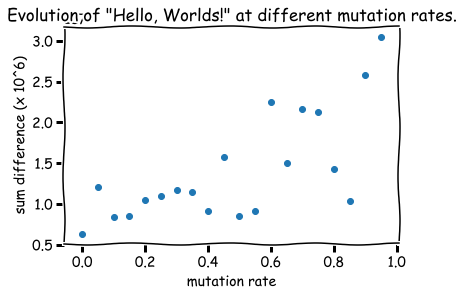

In [72]:
import numpy as np
import matplotlib.pyplot as plt

plt.ion()
plt.xkcd()
plt.title('Evolution of "Hello, Worlds!" at different mutation rates.')
plt.xlabel('mutation rate')
plt.ylabel('sum difference (x 10^6)')

def genotype(mutation_rate):
    population = Population(log_costs=True)
    population.genotype(mutation_rate=pct)
    s = sum(population.cost_log)
    print(mutation_rate, s)
    return s
    
population = Population(log_costs=True)
plt.scatter(np.arange(0.0, 1.0, 0.05), [genotype(pct) for pct in np.arange(0.0, 1.0, 0.05)])
plt.show()


That doesn't look right! How can the sum of the population cost log be 3.5 at maximum? Time to adjust the legend. 

10 28761294
15 7377764
20 20707397
25 8678587
30 10165245
35 16745470
40 12844382
45 8876407
50 11186589
55 10859624
60 5341964
65 8542118
70 7068542
75 7792111
80 6078594
85 14056062
90 5908043
95 11263643


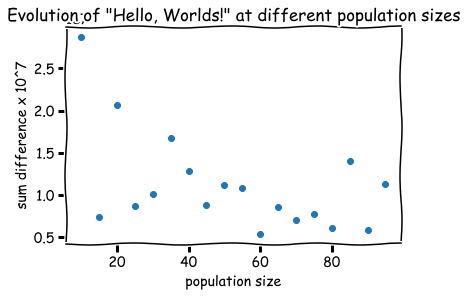

In [81]:
plt.ion()
plt.xkcd()
plt.title('Evolution of "Hello, Worlds!" at different population sizes')
plt.xlabel('population size')
plt.ylabel('sum difference x 10^7')

def genotype(population_size=100):
    population = Population("Hello, Worlds!", size=population_size, log_costs=True)
    population.genotype(mutation_rate=0.1)
    s = sum(population.cost_log)
    print(population_size, s)
    return s

plt.scatter(range(10, 100, 5), [genotype(pop_size) for pop_size in range(10, 100, 5)])
plt.show()